Notebook Color Schemes:


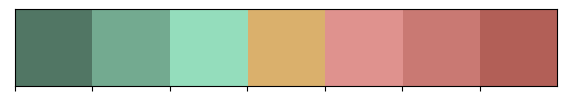

In [1]:
# General Libraries
import os
import re
import gc
import cv2
import wandb
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'
    
my_colors = ["#517664", "#73AA90", "#94DDBC", "#DAB06C", 
             "#DF928E", "#C97973", "#B25F57"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [2]:
! wandb login 764dffffed4dd6005dc348a366dfec816631f2cd

In [3]:
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [4]:
from sklearn.model_selection import train_test_split


In [5]:
from torch.cuda import empty_cache


In [6]:
class RSNADataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip,
                 is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        
        # Data Augmentation (custom for each dataset type)
        if is_train:
            self.transform = Compose([RandomResizedCrop(height=224, width=224),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      ToTensorV2()])
        else:
            self.transform = Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batcj at a time.'''
        
        # Select path and read image
        image_path = self.dataframe['path'][index]
        image = pydicom.dcmread(image_path).pixel_array.astype(np.float32)
        
        # For this image also import .csv information
        csv_data = np.array(self.dataframe.iloc[index][csv_columns].values, 
                            dtype=np.float32)
        # Apply transforms
        transf_image = self.transform(image=image)['image']
        # Change image from 1 channel (B&W) to 3 channels
        transf_image = np.concatenate([transf_image, transf_image, transf_image], axis=0)
        
        # Return info
        if self.is_train:
            return {"image": transf_image, 
                    "meta": csv_data, 
                    "target": self.dataframe['cancer'][index]}
        else:
            return {"image": transf_image, 
                    "meta": csv_data}

In [7]:
def data_to_device(data):
    
    image, metadata, targets = data.values()
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

In [8]:
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        # (metadata)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)
        
        
    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [9]:
def add_in_file(text, f):
    
    with open(f'logs_{VERSION}.txt', 'a+') as f:
        print(text, file=f)

In [10]:
# def train_folds(model, train_original):
#     # Creates a .txt file that will contain the logs
#     # logs == what we also print to console
#     f = open(f"logs_{VERSION}.txt", "w+")
    
#     # Split in folds
#     group_fold = GroupKFold(n_splits = FOLDS)

#     # Generate indices to split data into training and test set.
#     k_folds = group_fold.split(X = np.zeros(len(train_original)), 
#                                y = train_original['cancer'], 
#                                groups = train_original['patient_id'].tolist())
    
#     # For each fold
#     for i, (train_index, valid_index) in enumerate(k_folds):
        
#         print(clr.S+f"---------- Fold: {i+1} ----------"+clr.E)
#         add_in_file(f"---------- Fold: {i+1} ----------", f)
        
#         # 🐝 W&B Tracking
#         RUN_CONFIG = CONFIG.copy()
#         params = dict(model=MODEL, 
#                       version=VERSION,
#                       fold=i,
#                       epochs=EPOCHS, 
#                       batch=BATCH_SIZE1,
#                       lr=LR,
#                       weight_decay=WD)
#         RUN_CONFIG.update(params)
#         run = wandb.init(project='RSNA_Breast_Cancer', config=RUN_CONFIG)

#         wandb.watch(model, log_freq=100) # 🐝

#         # --- Create Instances ---
#         # Best ROC score in this fold
#         best_roc = None
#         # Reset patience before every fold
#         patience_f = PATIENCE

#         # Optimizer/ Scheduler/ Criterion
#         optimizer = torch.optim.Adam(model.parameters(), lr = LR, 
#                                      weight_decay=WD)
#         scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
#                                       patience=LR_PATIENCE, verbose=True, factor=LR_FACTOR)
#         criterion = nn.BCEWithLogitsLoss()


#         # --- Read in Data ---
#         train_data = train_original.iloc[train_index].reset_index(drop=True)
#         valid_data = train_original.iloc[valid_index].reset_index(drop=True)

#         # Create Data instances
#         train = RSNADataset(train_data, vertical_flip, horizontal_flip, 
#                             is_train=True)
#         valid = RSNADataset(valid_data, vertical_flip, horizontal_flip,
#                             is_train=True)

#         # Dataloaders
#         train_loader = DataLoader(train, batch_size=BATCH_SIZE1, 
#                                   shuffle=True, num_workers=WORKERS)
#         valid_loader = DataLoader(valid, batch_size=BATCH_SIZE2, 
#                                   shuffle=False, num_workers=WORKERS)

#         train_acc_list, train_loss_list, train_auc_list = [], [], []
#         valid_acc_list, valid_loss_list, valid_auc_list = [], [], []
#         # === EPOCHS ===
#         for epoch in range(EPOCHS):
#             start_time = time()
#             # Reset metryk dla bieżącej epoki
#             train_acc_list = []
#             train_loss_list = []
#             train_auc_list = []
#             valid_acc_list = []
#             valid_loss_list = []
#             valid_auc_list = []
#             correct = 0
#             train_losses = 0
#                         # Puste zmienne do przechowywania metryk dla bieżącej epoki
#             train_correct = 0
#             train_losses = 0
#             train_preds_list, train_labels_list = [], []

#             # === TRAIN ===
#             # Sets the module in training mode.
#             model.train()

#             # For each batch
#             for k, data in tqdm(enumerate(train_loader)):
#                 # Save them to device
#                 image, meta, targets = data_to_device(data)

#                 # Clear gradients first; very important
#                 # usually done BEFORE prediction
#                 optimizer.zero_grad()

#                 # Log Probabilities & Backpropagation
#                 out = model(image, meta)
#                 loss = criterion(out, targets.unsqueeze(1).float())
#                 train_losses += loss.item()
#                 train_preds = torch.round(torch.sigmoid(out))
#                 train_correct += (train_preds.float().cpu() == targets.float().cpu().unsqueeze(1)).sum().item()                
#                 loss.backward()
#                 optimizer.step()

#                 # --- Save information after this batch ---
#                 # Save loss
#                # train_losses += loss.item()
#                 wandb.log({"train_loss": loss.item()}, step=epoch) # 🐝
#                 # From log probabilities to actual probabilities
#                # train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
#                 # Number of correct predictions
#                # correct += (train_preds.float().cpu() == targets.float().cpu().unsqueeze(1)).sum().item()
#                         # Dodawanie prognoz i etykiet do list
#                 train_preds_list.extend(train_preds.detach().cpu().numpy())

#                 train_labels_list.extend(targets.cpu().numpy())
#                # train_labels_list.extend(targets.detach().cpu().numpy()) 
                

#                 # Obliczanie i rejestrowanie metryk treningowych
#                 train_acc = train_correct / len(train_index)
#                 train_loss = train_losses / len(train_loader)
#                 #train_auc = roc_auc_score(targets.cpu().detach().numpy(), train_preds.cpu().detach().numpy())
#                 #train_data['cancer'].values, train_preds_list
                
#                 train_acc_list.append(train_acc)
#                 train_loss_list.append(train_loss)
#                 #train_auc_list.append(train_auc)
#                 #empty_cache()

#             # Compute Train Accuracy
#             #train_acc = correct / len(train_index)
#             wandb.log({"train_acc": train_acc}) # 🐝


#             # === EVAL ===
#             # Sets the model in evaluation mode.
#             model.eval()

#             # Create matrix to store evaluation predictions (for accuracy)
#             valid_preds = torch.zeros(size = (len(valid_index), 1), 
#                                       device=DEVICE, dtype=torch.float32)
           


#             # Disables gradients (we need to be sure no optimization happens)
#             with torch.no_grad():
#                 valid_preds_list, valid_labels_list = [], []
#                 for k, data in tqdm(enumerate(valid_loader)):
#                     # Save them to device
#                     image, meta, targets = data_to_device(data)

#                     out = model(image, meta)
#                     pred = torch.sigmoid(out)
#                     valid_preds[k*image.shape[0] : k*image.shape[0] + image.shape[0]] = pred
#                     valid_preds_list.extend(pred.cpu().numpy())
#                     valid_labels_list.extend(targets.cpu().numpy())
#                     valid_acc = accuracy_score(valid_data['cancer'].values, np.round(valid_preds.cpu()))
#                     valid_loss = criterion(out,targets.unsqueeze(1).float())

#                   #  valid_auc = roc_auc_score(valid_data['cancer'].values, valid_preds_list)
#                     valid_acc_list.append(valid_acc)
#                     valid_loss_list.append(valid_loss)
#                    # valid_auc_list.append(valid_auc)
#                 # Calculate accuracy
#                 valid_acc = accuracy_score(valid_data['cancer'].values, 
#                                            torch.round(valid_preds.cpu()))
#                 wandb.log({"valid_acc": valid_acc}) # 🐝
#                 # Calculate ROC
#                 valid_roc = roc_auc_score(valid_data['cancer'].values, 
#                                           valid_preds.cpu())
#                 wandb.log({"valid_roc": valid_roc}) # 🐝

#                 # Calculate time on Train + Eval
#                 duration = str(dtime.timedelta(seconds=time() - start_time))[:7]


#                 # PRINT INFO
#                 final_logs = '{} | Epoch: {}/{} | Loss: {:.4} | Acc_tr: {:.3} | Acc_vd: {:.3} | ROC: {:.3}'.\
#                                 format(duration, epoch+1, EPOCHS, 
#                                        train_losses, train_acc, valid_acc, valid_roc)
#                 add_in_file(final_logs,f)
#                                     # Obliczanie i rejestrowanie metryk walidacyjnych

#                 print(final_logs)


#                 # === SAVE MODEL ===

#                 # Update scheduler (for learning_rate)
#                 scheduler.step(valid_roc)
#                 # Name the model
#                 model_name = f"Fold{i+1}_Epoch{epoch+1}_ValidAcc{valid_acc:.3f}_ROC{valid_roc:.3f}.pth"

#                 # Update best_roc
#                 if not best_roc: # If best_roc = None
#                     best_roc = valid_roc
#                     torch.save(model.state_dict(), model_name)
#                     continue

#                 if valid_roc > best_roc:
#                     best_roc = valid_roc
#                     # Reset patience (because we have improvement)
#                     patience_f = PATIENCE
#                     torch.save(model.state_dict(), model_name)
#                 else:
#                     # Decrease patience (no improvement in ROC)
#                     patience_f = patience_f - 1
#                     if patience_f == 0:
#                         stop_logs = 'Early stopping (no improvement since 3 models) | Best ROC: {}'.\
#                                     format(best_roc)
#                         add_in_file(stop_logs, f)
#                         print(stop_logs)
#                         break


#             # Wizualizacja metryk dla treningu i walidacji
#             plt.figure(figsize=(12, 6))
#             epochs = np.arange(1, EPOCHS + 1)
#             plt.subplot(1, 3, 1)
#             plt.plot(epochs, train_acc_list, label='Train Accuracy')
#             plt.plot(epochs, valid_acc_list, label='Validation Accuracyf')
#             plt.legend()
#             plt.xlabel('Epochs')
#             plt.ylabel('Accuracy')
#             plt.title('Accuracy During Training')

#             plt.subplot(1, 3, 2)
#             plt.plot(epochs, train_loss_list, label='Train Loss')
#             plt.plot(epochs, valid_loss_list, label='Validation Loss')
#             plt.legend()
#             plt.xlabel('Epochs')
#             plt.ylabel('Loss')
#             plt.title('Loss During Training')

# #             plt.subplot(1, 3, 3)
# #             plt.plot(epochs, train_auc_list, label='Train AUC')
# #             plt.plot(epochs, valid_auc_list, label='Validation AUC')
# #             plt.legend()
# #             plt.xlabel('Epochs')
# #             plt.ylabel('AUC')
# #             plt.title('AUC During Training')

#             plt.tight_layout()
#             plt.show()
#         # === CLEANING ===
#         # Clear memory
#         del train, valid, train_loader, valid_loader, image, targets
#         gc.collect()
        
#         # 🐝 Experiment End for this fold
#         wandb.finish()

In [11]:
def train_folds(model, train_original):
    # Creates a .txt file that will contain the logs
    # logs == what we also print to console
    f = open(f"logs_{VERSION}.txt", "w+")
    
    # Split in folds
    group_fold = GroupKFold(n_splits = FOLDS)

    # Generate indices to split data into training and test set.
    k_folds = group_fold.split(X = np.zeros(len(train_original)), 
                               y = train_original['cancer'], 
                               groups = train_original['patient_id'].tolist())
    
    # For each fold
    for i, (train_index, valid_index) in enumerate(k_folds):
        
        print(clr.S+f"---------- Fold: {i+1} ----------"+clr.E)
        add_in_file(f"---------- Fold: {i+1} ----------", f)
        
        # 🐝 W&B Tracking
        RUN_CONFIG = CONFIG.copy()
        params = dict(model=MODEL, 
                      version=VERSION,
                      fold=i,
                      epochs=EPOCHS, 
                      batch=BATCH_SIZE1,
                      lr=LR,
                      weight_decay=WD)
        RUN_CONFIG.update(params)
        run = wandb.init(project='RSNA_Breast_Cancer', config=RUN_CONFIG)

        wandb.watch(model, log_freq=100) # 🐝

        # --- Create Instances ---
        # Best ROC score in this fold
        best_roc = None
        # Reset patience before every fold
        patience_f = PATIENCE

        # Optimizer/ Scheduler/ Criterion
        optimizer = torch.optim.Adam(model.parameters(), lr = LR, 
                                     weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=LR_PATIENCE, verbose=True, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss()


        # --- Read in Data ---
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)

        # Create Data instances
        train = RSNADataset(train_data, vertical_flip, horizontal_flip, 
                            is_train=True)
        valid = RSNADataset(valid_data, vertical_flip, horizontal_flip,
                            is_train=True)

        # Dataloaders
        train_loader = DataLoader(train, batch_size=BATCH_SIZE1, 
                                  shuffle=True, num_workers=WORKERS)
        valid_loader = DataLoader(valid, batch_size=BATCH_SIZE2, 
                                  shuffle=False, num_workers=WORKERS)


        # === EPOCHS ===
        train_acc_epochs = []
        train_loss_epochs = []
        valid_acc_epochs = []
       # valid_loss_epochs = []
        valid_roc_epochs = []
        # === EPOCHS ===
        for epoch in range(EPOCHS):
            start_time = time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            # Sets the module in training mode.
            model.train()

            # For each batch
            for k, data in tqdm(enumerate(train_loader)):
                # Save them to device
                image, meta, targets = data_to_device(data)

                # Clear gradients first; very important
                # usually done BEFORE prediction
                optimizer.zero_grad()

                # Log Probabilities & Backpropagation
                out = model(image, meta)
                loss = criterion(out, targets.unsqueeze(1).float())
                loss.backward()
                optimizer.step()

                # --- Save information after this batch ---
                # Save loss
                train_losses += loss.item()
                wandb.log({"train_loss": loss.item()}, step=epoch) # 🐝
                # From log probabilities to actual probabilities
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                # Number of correct predictions
                correct += (train_preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()

            # Compute Train Accuracy
            train_acc = correct / len(train_index)
            wandb.log({"train_acc": train_acc}) # 🐝


            # === EVAL ===
            # Sets the model in evaluation mode.
            model.eval()

            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1), 
                                      device=DEVICE, dtype=torch.float32)


            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                for k, data in tqdm(enumerate(valid_loader)):
                    # Save them to device
                    image, meta, targets = data_to_device(data)

                    out = model(image, meta)
                    pred = torch.sigmoid(out)
                    valid_preds[k*image.shape[0] : k*image.shape[0] + image.shape[0]] = pred

                # Calculate accuracy
                valid_acc = accuracy_score(valid_data['cancer'].values, 
                                           torch.round(valid_preds.cpu()))
               # valid_loss = criterion(out.squeeze(),targets)
                wandb.log({"valid_acc": valid_acc}) # 🐝
                # Calculate ROC
                valid_roc = roc_auc_score(valid_data['cancer'].values, 
                                          valid_preds.cpu())
                wandb.log({"valid_roc": valid_roc}) # 🐝
            
                # Calculate time on Train + Eval
                duration = str(dtime.timedelta(seconds=time() - start_time))[:7]


                # PRINT INFO
                final_logs = '{} | Epoch: {}/{} | Loss: {:.4} | Acc_tr: {:.3} | Acc_vd: {:.3} | ROC: {:.3}'.\
                                format(duration, epoch+1, EPOCHS, 
                                       train_losses, train_acc, valid_acc, valid_roc)
                add_in_file(final_logs,f)
                print(final_logs)

                train_acc_epochs.append(train_acc)
                train_loss_epochs.append(train_losses)
                valid_acc_epochs.append(valid_acc)
               # valid_loss_epochs.append(valid_loss)
                valid_roc_epochs.append(valid_roc)

                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)
                # Name the model
                model_name = f"Fold{i+1}_Epoch{epoch+1}_ValidAcc{valid_acc:.3f}_ROC{valid_roc:.3f}.pth"

                # Update best_roc
                if not best_roc: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(), model_name)
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = PATIENCE
                    torch.save(model.state_dict(), model_name)
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        stop_logs = 'Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                    format(best_roc)
                        add_in_file(stop_logs, f)
                        print(stop_logs)
                        break


        # === CLEANING ===
        # Clear memory

        # Visualization
        epochs = np.arange(1, epoch + 2)

        plt.figure(figsize=(12, 6))
#         plt.subplot(1, 2, 1)
#         plt.plot(epochs, train_loss_epochs, label='Train Loss')
#         plt.plot(epochs, valid_loss_epochs, label='Validation Loss')
#         plt.legend()
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.title('Loss During Training')

       # plt.subplot(1, 2, 2)
       # plt.plot(epochs, train_loss_epochs, label='Train Loss')
        plt.plot(epochs, train_acc_epochs, label='Train Accuracy')
        plt.plot(epochs, valid_acc_epochs, label='Validation Accuracy')
        plt.plot(epochs, valid_roc_epochs, label='Validation ROC AUC')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Metric Value')
        plt.title('Metrics During Training')

        plt.tight_layout()
        plt.show()
        del train, valid, train_loader, valid_loader, image, targets
        gc.collect()
        # 🐝 Experiment End for this fold
        wandb.finish()

In [13]:
# Seed
#set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

# Read in Data
train1 = pd.read_csv("/media/jan.solarz/PortableSSD/train_main_0.8.csv")

Device available now: cuda


In [13]:
#train2 = pd.read_csv("/media/jan.solarz/PortableSSD/kaggle/input/rsna-breast-cancer-detection/train.csv")

In [14]:
#train2.density = train2.density.replace(np.nan,'E')

In [15]:
train1

,Unnamed: 0,patient_id,image_id,laterality,view,age,implant,path,cancer,density
0,37048,49757,848767835,1,1,61.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,4
1,26676,38534,849753090,1,1,51.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,1
2,26880,38727,1338411990,0,5,65.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,1
3,17359,2837,1973065608,0,5,73.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,4
4,30802,42978,281036321,1,5,64.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,4
...,...,...,...,...,...,...,...,...,...,...
43759,29853,41864,2095994743,0,5,51.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,1
43760,25110,36847,1148072336,0,1,61.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,3
43761,3665,13909,1054329984,1,1,42.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,3
43762,35929,48552,1961541480,0,1,57.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,4


In [16]:
# le_density = LabelEncoder()

# train2['density'] = le_density.fit_transform(train2['density'])


In [17]:
from collections import Counter

In [18]:
Counter(train1.density)

Counter({4: 20139, 1: 10158, 2: 9767, 0: 2455, 3: 1245})

In [19]:
Counter(train1.cancer)

Counter({0: 42838, 1: 926})

In [20]:
#train1['density'] = train2['density']

In [21]:
#test, bierzemy 0.1 traina do sprawdzenia czy wszystko działa

In [37]:
# train_df, test_df = train_test_split(train1, 
#                                    test_size = 0.20, 
#                                    random_state = 2000,
#                                    stratify = train[['cancer']])

In [38]:
# train_df.to_csv("/media/jan.solarz/PortableSSD/train_main_0.8.csv")
# test_df.to_csv("/media/jan.solarz/PortableSSD/test_main_0.2.csv")

In [14]:
# ----- GLOBAL PARAMS -----
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['laterality', 'view', 'age', 'implant','density']
no_columns = len(csv_columns)
output_size = 1
# -------------------------

In [23]:
from collections import Counter

In [24]:
Counter(train.cancer)

NameError: name 'train' is not defined

---------- Fold: 1 ----------


1368it [38:46,  1.70s/it]
2736it [39:35,  1.15it/s]

1:18:21 | Epoch: 1/5 | Loss: 155.7 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.657



1368it [41:24,  1.82s/it]
2736it [40:11,  1.13it/s]

1:21:36 | Epoch: 2/5 | Loss: 141.7 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.632



1368it [41:56,  1.84s/it]
2736it [39:47,  1.15it/s]

1:21:44 | Epoch: 3/5 | Loss: 140.5 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.653
Epoch 00003: reducing learning rate of group 0 to 2.0000e-04.



1368it [44:05,  1.93s/it]
2736it [48:51,  1.07s/it]


1:32:57 | Epoch: 4/5 | Loss: 136.2 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.622
Early stopping (no improvement since 3 models) | Best ROC: 0.657455824828573


ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

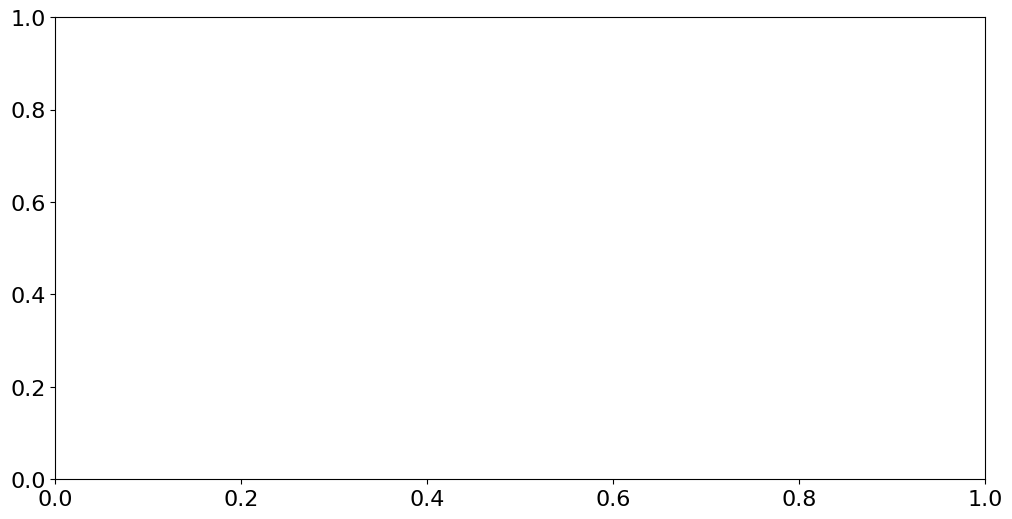

In [20]:
FOLDS = 2
EPOCHS = 5
PATIENCE = 3
WORKERS = 8
LR = 0.0005
WD = 0.0
LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
LR_FACTOR = 0.4            # by how much the lr is decreasing

BATCH_SIZE1 = 16          # for train
BATCH_SIZE2 = 8           # for valid

VERSION = 'v1'
MODEL = 'resnet50'

model1 = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# ------------------

# Run the cell below to train
# Ran it locally on all data, see the results below
train_folds(model=model1, train_original=train1)

---------- Fold: 1 ----------


1368it [45:33,  2.00s/it]
2736it [46:29,  1.02s/it]

1:32:03 | Epoch: 1/5 | Loss: 158.0 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.647



1368it [46:11,  2.03s/it]
2736it [41:11,  1.11it/s]

1:27:23 | Epoch: 2/5 | Loss: 142.1 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.65



1368it [43:38,  1.91s/it]
2736it [43:37,  1.05it/s]

1:27:16 | Epoch: 3/5 | Loss: 139.8 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.608



1368it [42:53,  1.88s/it]
2736it [43:09,  1.06it/s]

1:26:04 | Epoch: 4/5 | Loss: 138.4 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.642
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.



1368it [43:48,  1.92s/it]
2736it [43:26,  1.05it/s]

1:27:15 | Epoch: 5/5 | Loss: 135.1 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.516
Early stopping (no improvement since 3 models) | Best ROC: 0.6499230207531722


ValueError: x and y must have same first dimension, but have shapes (4,) and (5,)

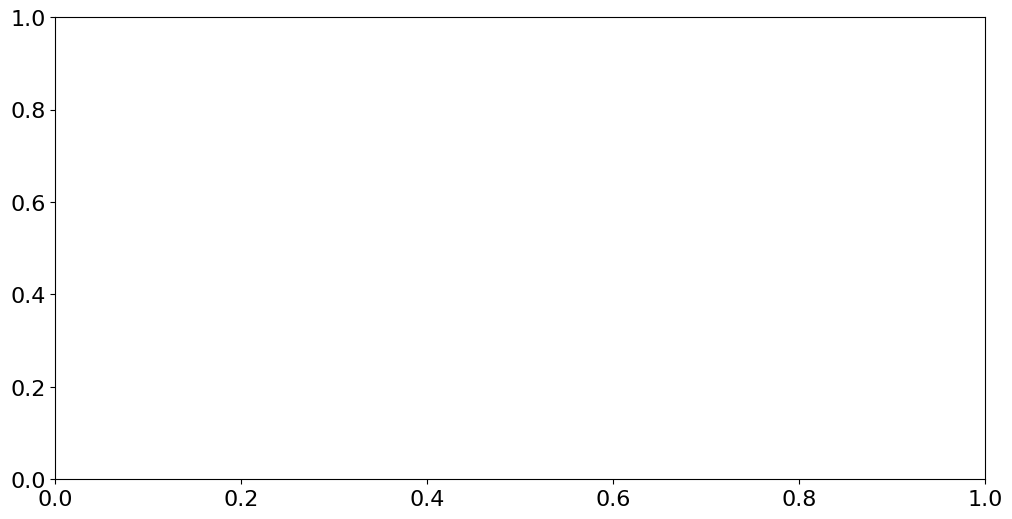

In [22]:
FOLDS = 2
EPOCHS = 5
PATIENCE = 3
WORKERS = 8
LR = 0.0005
WD = 0.0
LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
LR_FACTOR = 0.4            # by how much the lr is decreasing

BATCH_SIZE1 = 16          # for train
BATCH_SIZE2 = 8           # for valid

VERSION = 'v1'
MODEL = 'resnet50'

model1 = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# ------------------

# Run the cell below to train
# Ran it locally on all data, see the results below
train_folds(model=model1, train_original=train1)

In [ ]:
torch.save(model1.state_dict(), '/media/jan.solarz/PortableSSD/resnet_model_0.8_main.pth')

---------- Fold: 1 ----------


171it [04:21,  1.53s/it]
342it [04:46,  1.19it/s]

0:09:08 | Epoch: 1/2 | Loss: 27.85 | Acc_tr: 0.974 | Acc_vd: 0.98 | ROC: 0.546



171it [04:53,  1.72s/it]
342it [04:54,  1.16it/s]


0:09:49 | Epoch: 2/2 | Loss: 20.51 | Acc_tr: 0.976 | Acc_vd: 0.98 | ROC: 0.47


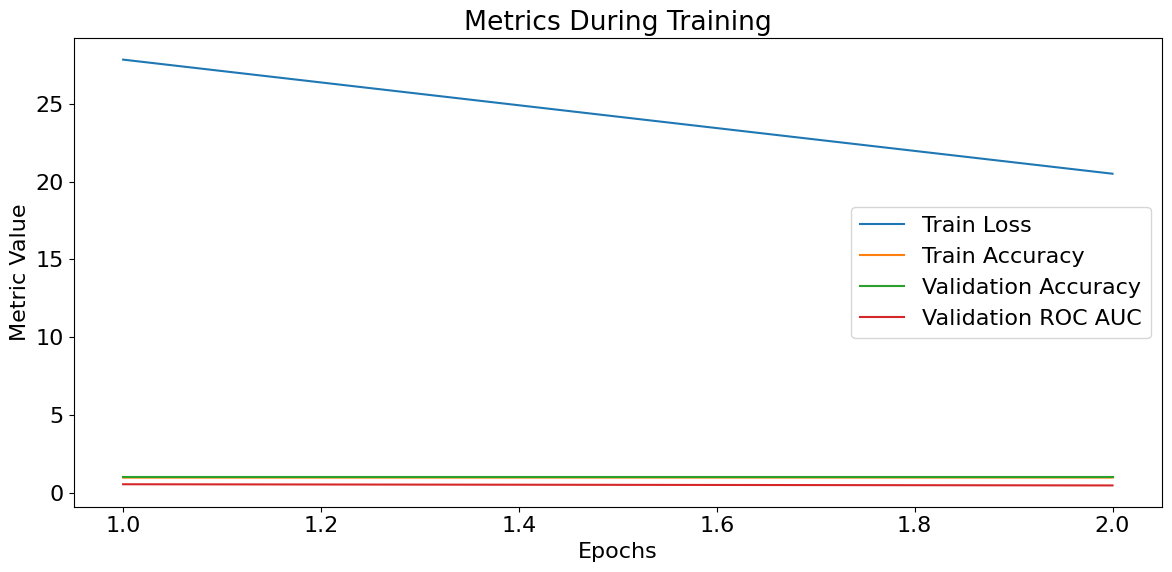

---------- Fold: 2 ----------


170it [04:52,  1.72s/it]


KeyboardInterrupt: 

In [22]:
FOLDS = 2
EPOCHS = 5
PATIENCE = 3
WORKERS = 8
LR = 0.0005
WD = 0.0
LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
LR_FACTOR = 0.4            # by how much the lr is decreasing

BATCH_SIZE1 = 16          # for train
BATCH_SIZE2 = 8           # for valid

VERSION = 'v1'
MODEL = 'resnet50'

model1 = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# ------------------

# Run the cell below to train
# Ran it locally on all data, see the results below
train_folds(model=model1, train_original=train1)

---------- Fold: 1 ----------


1368it [53:00,  2.32s/it]
2736it [45:54,  1.01s/it]


1:38:55 | Epoch: 1/5 | Loss: 157.6 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.626


1368it [45:54,  2.01s/it]
2736it [43:59,  1.04it/s]

1:29:54 | Epoch: 2/5 | Loss: 141.8 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.627



1368it [47:38,  2.09s/it]
2736it [45:40,  1.00s/it]


1:33:19 | Epoch: 3/5 | Loss: 139.4 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.644


1368it [50:23,  2.21s/it]
2736it [48:04,  1.05s/it]

1:38:29 | Epoch: 4/5 | Loss: 139.4 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.63



1368it [50:09,  2.20s/it]
2736it [45:20,  1.01it/s]


1:35:29 | Epoch: 5/5 | Loss: 139.7 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.629
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.


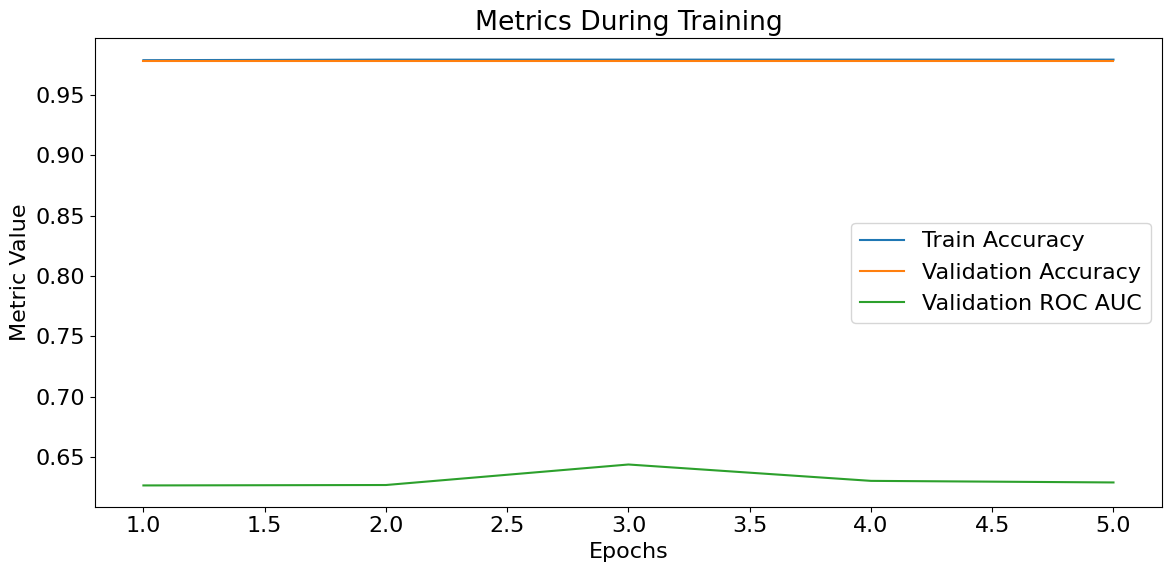

---------- Fold: 2 ----------


1368it [44:48,  1.97s/it]
2736it [44:07,  1.03it/s]


1:28:56 | Epoch: 1/5 | Loss: 145.5 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.617


1368it [46:12,  2.03s/it]
2736it [45:37,  1.00s/it]


1:31:49 | Epoch: 2/5 | Loss: 145.3 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.649


1368it [47:18,  2.08s/it]
2736it [45:49,  1.00s/it]

1:33:08 | Epoch: 3/5 | Loss: 143.9 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.612



1368it [45:37,  2.00s/it]
2736it [44:28,  1.03it/s]

1:30:07 | Epoch: 4/5 | Loss: 144.9 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.638
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.



1368it [45:24,  1.99s/it]
2736it [44:34,  1.02it/s]


1:29:59 | Epoch: 5/5 | Loss: 140.1 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.643
Early stopping (no improvement since 3 models) | Best ROC: 0.6491190052414902


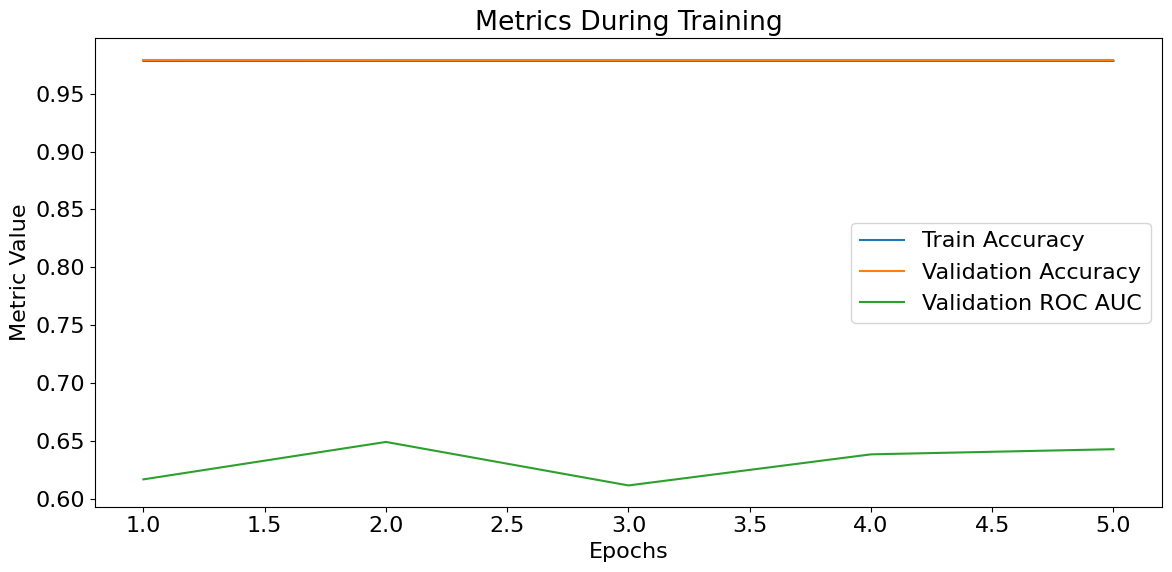

In [37]:
FOLDS = 2
EPOCHS = 5
PATIENCE = 3
WORKERS = 8
LR = 0.0005
WD = 0.0
LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
LR_FACTOR = 0.4            # by how much the lr is decreasing

BATCH_SIZE1 = 16          # for train
BATCH_SIZE2 = 8           # for valid

VERSION = 'v1'
MODEL = 'resnet50'

model1 = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# ------------------

# Run the cell below to train
# Ran it locally on all data, see the results below
train_folds(model=model1, train_original=train1)

In [38]:
torch.save(model1.state_dict(), '/media/jan.solarz/PortableSSD/resnet_model_0.8_main.pth')

In [307]:
class EffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b4')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(2042, self.output_size))
        
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, image.shape[1])
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [26]:
# Sample data
sample_df = train1.head(6)

# Instantiate Dataset object
dataset = RSNADataset(sample_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(clr.S + f"Batch: {k}" + clr.E, "\n" +
          clr.S + "Image:" + clr.E, image.shape, "\n" +
          clr.S + "Meta:" + clr.E, meta, "\n" +
          clr.S + "Targets:" + clr.E, targets, "\n" +
          "="*50)

Batch: 0 
Image: torch.Size([3, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 61.,  0.,  4.],
        [ 1.,  1., 51.,  0.,  1.],
        [ 0.,  5., 65.,  0.,  1.]], device='cuda:0') 
Targets: tensor([0, 0, 1], device='cuda:0') 
Batch: 1 
Image: torch.Size([3, 3, 224, 224]) 
Meta: tensor([[ 0.,  5., 73.,  0.,  4.],
        [ 1.,  5., 64.,  0.,  4.],
        [ 1.,  1., 52.,  0.,  4.]], device='cuda:0') 
Targets: tensor([0, 0, 0], device='cuda:0') 


In [27]:
model_example2 = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Outputs
out = model_example2(image, meta, prints=True)

# Criterion example
criterion_example = nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 
print("="*50)
print(clr.S+'Loss:'+clr.E, loss.item())

Loaded pretrained weights for efficientnet-b4
Input Image shape: torch.Size([3, 3, 224, 224]) 
Input metadata shape: torch.Size([3, 5])
Features Image shape: torch.Size([3, 1792])
Meta Data: torch.Size([3, 250])
Concatenated Data: torch.Size([3, 2042])
Out shape: torch.Size([3, 1])
Loss: 0.6272611021995544


Loaded pretrained weights for efficientnet-b4
---------- Fold: 1 ----------


1368it [45:07,  1.98s/it]
2736it [46:12,  1.01s/it]


1:31:20 | Epoch: 1/5 | Loss: 143.3 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.622


1368it [46:02,  2.02s/it]
2736it [45:53,  1.01s/it]

1:31:56 | Epoch: 2/5 | Loss: 136.5 | Acc_tr: 0.979 | Acc_vd: 0.957 | ROC: 0.648



1368it [1:00:49,  2.67s/it]
2736it [48:44,  1.07s/it]


1:49:35 | Epoch: 3/5 | Loss: 135.8 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.637


1368it [1:17:25,  3.40s/it]
2736it [50:55,  1.12s/it]

2:08:21 | Epoch: 4/5 | Loss: 136.2 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.633
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.



1368it [1:00:40,  2.66s/it]
2736it [50:07,  1.10s/it]


1:50:48 | Epoch: 5/5 | Loss: 135.6 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.653


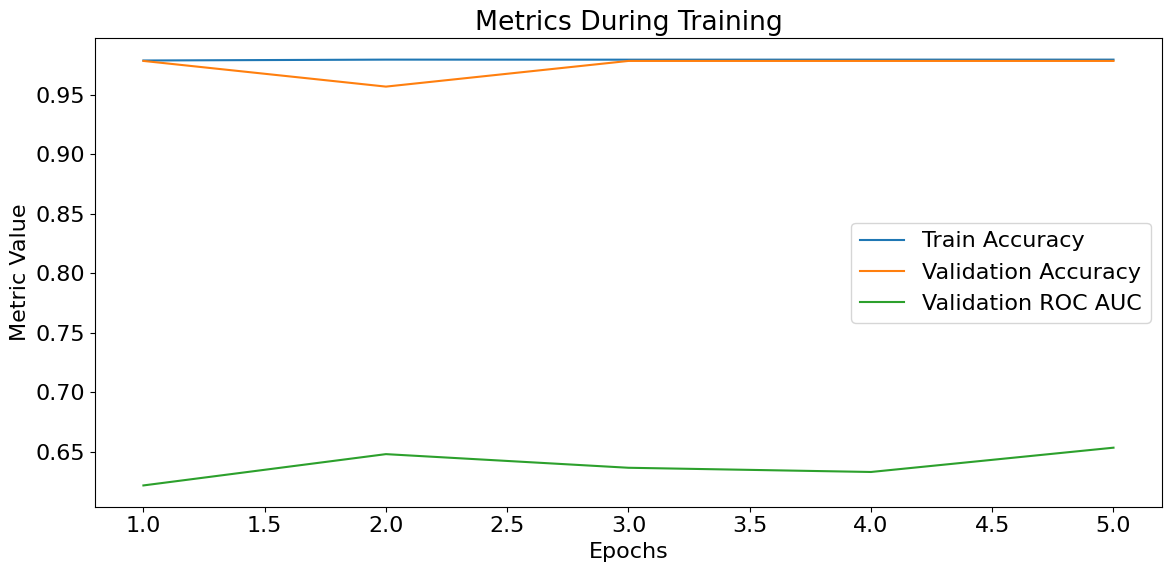

---------- Fold: 2 ----------


1368it [1:08:49,  3.02s/it]
2736it [50:26,  1.11s/it]


1:59:16 | Epoch: 1/5 | Loss: 141.5 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.646


1368it [1:01:15,  2.69s/it]
2736it [50:27,  1.11s/it]

1:51:43 | Epoch: 2/5 | Loss: 141.7 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.644



1368it [1:02:17,  2.73s/it]
2736it [49:46,  1.09s/it]

1:52:04 | Epoch: 3/5 | Loss: 140.8 | Acc_tr: 0.978 | Acc_vd: 0.965 | ROC: 0.632
Epoch 00003: reducing learning rate of group 0 to 2.0000e-04.



1368it [1:01:57,  2.72s/it]
2736it [49:38,  1.09s/it]


1:51:36 | Epoch: 4/5 | Loss: 140.0 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.645
Early stopping (no improvement since 3 models) | Best ROC: 0.6464721359664973


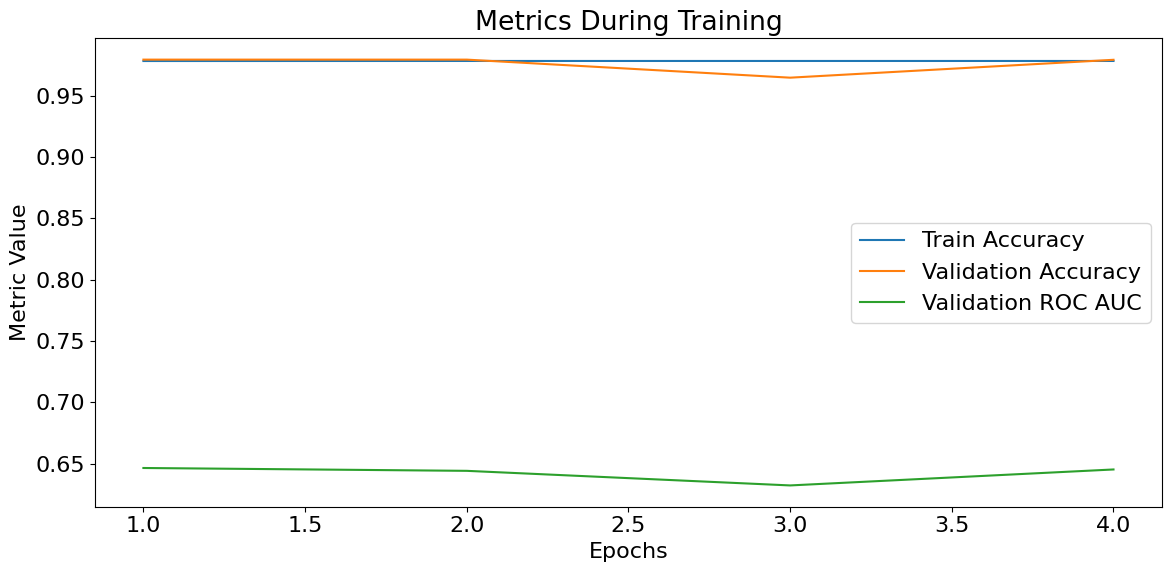

In [19]:
FOLDS = 2
EPOCHS = 5
PATIENCE = 3
WORKERS = 8
LR = 0.0005
WD = 0.0
LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
LR_FACTOR = 0.4            # by how much the lr is decreasing

BATCH_SIZE1 = 16          # for train
BATCH_SIZE2 = 8           # for valid

VERSION = 'v1'
MODEL = 'effnet'

model1 = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# ------------------

# Run the cell below to train
# Ran it locally on all data, see the results below
train_folds(model=model1, train_original=train1)

In [25]:
# Predykcja Resnet

In [20]:
torch.save(model1.state_dict(), '/media/jan.solarz/PortableSSD/effnet_model_0.8_main.pth')

In [14]:
model1 = ResNet50Network(output_size=1, no_columns=no_columns)
#model.to('cuda')

# Wczytanie wag zapisanych w pliku
model1.load_state_dict(torch.load('/media/jan.solarz/PortableSSD/resnet_model_0.8_main.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

# Przygotowanie modelu (zakładając, że już zdefiniowany i wytrenowany)
# model = ResNet50Network(output_size=1, no_columns=your_number_of_columns)
# model.load_state_dict(torch.load('best_model.pth'))  # Wczytanie wytrenowanego modelu

# Przygotowanie modelu do testowania (ustawienie w tryb ewaluacji)
#model1.eval()

# # Przechowywanie predykcji i prawdziwych etykiet dla danych testowych
# test_preds = []
# test_labels = []

In [16]:
def calculate_metrics(labels, preds):
    auc = roc_auc_score(labels, preds)
    f1 = f1_score(labels, np.round(preds))
    accuracy = accuracy_score(labels, np.round(preds))
    recall = recall_score(labels, np.round(preds))
    precision = precision_score(labels, np.round(preds))
    return {'AUC': auc, 'F1': f1, 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision}


In [26]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

# Read in Data
test_df = pd.read_csv("/media/jan.solarz/PortableSSD/test_main_0.2.csv")
train = pd.read_csv("/media/jan.solarz/PortableSSD/train_main_0.8.csv")

Device available now: cuda


In [18]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev=torch.device("cuda") 
model1.to(dev)

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [19]:
test_df_0 = test_df[test_df.cancer == 1].reset_index().head(100)
test_df_1 = test_df[test_df.cancer == 0].reset_index().head(100)
test_df = pd.concat([test_df_0,test_df_1]).reset_index()

In [26]:
dataset = RSNADataset(train, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
test_loader = DataLoader(dataset, batch_size=3, shuffle=False)

In [114]:
# Wycena właściwa
test_preds = []
test_labels = []

# Przechodzenie przez dane testowe i uzyskiwanie predykcji
with torch.no_grad():
    for data in test_loader:
        images, meta, labels = data_to_device(data)  # Załóż, że masz funkcję data_to_device
        outputs = model1(images, meta)
        preds = torch.sigmoid(outputs)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

In [29]:
# Tworzenie macierzy pomyłek
confusion_mat = confusion_matrix(test_labels, test_preds)

# Wyświetlanie macierzy pomyłek jako heatmapy
class_names = ['Class 0', 'Class 1', 'Class 2', ...]  # Zastąp odpowiednimi nazwami klas
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [30]:
test_preds_main = test_preds

In [ ]:
test_preds = test_preds_main

In [31]:
test_metrics = calculate_metrics(test_labels, test_preds)
print("Test Metrics:", test_metrics)

Test Metrics: {'AUC': 0.656669604720058, 'F1': 0.0, 'Accuracy': 0.9788410565761814, 'Recall': 0.0, 'Precision': 0.0}


In [ ]:
preds = []
for i in test_preds:
    if i < 0.01:
        preds.append(0)
    else:
        preds.append(1)
test_preds = preds

In [32]:
table_test = pd.DataFrame({'labels':test_labels,'preds':test_preds.flatten()})

In [33]:
table_test_1 = table_test[table_test.labels == 1]
table_test_0 = table_test[table_test.labels == 0]

(array([3132., 5345., 5428., 6088., 4986., 3664., 3088., 2292., 1808.,
        1280., 1035.,  789.,  660.,  578.,  476.,  424.,  375.,  284.,
         228.,  210.,  169.,  136.,  103.,   79.,   66.,   49.,   32.,
          14.,   11.,    9.]),
 array([1.2507958e-18, 3.2972200e-03, 6.5944400e-03, 9.8916600e-03,
        1.3188880e-02, 1.6486099e-02, 1.9783320e-02, 2.3080539e-02,
        2.6377760e-02, 2.9674979e-02, 3.2972198e-02, 3.6269419e-02,
        3.9566640e-02, 4.2863861e-02, 4.6161078e-02, 4.9458299e-02,
        5.2755520e-02, 5.6052737e-02, 5.9349958e-02, 6.2647179e-02,
        6.5944396e-02, 6.9241621e-02, 7.2538838e-02, 7.5836055e-02,
        7.9133280e-02, 8.2430497e-02, 8.5727721e-02, 8.9024939e-02,
        9.2322156e-02, 9.5619380e-02, 9.8916598e-02], dtype=float32),
 <BarContainer object of 30 artists>)

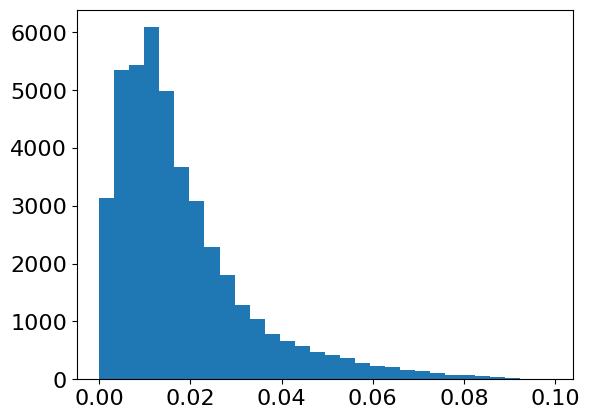

In [36]:
plt.hist(table_test_0.preds[table_test_0.preds > 0.00],30)

(array([13., 21., 19., 24., 46., 33., 47., 41., 49., 51., 38., 37., 44.,
        37., 46., 37., 26., 32., 21., 22., 10., 10.,  9., 13.,  8., 10.,
        15., 14., 13., 19., 11., 14., 14., 12.,  9.,  8.,  6.,  9.,  4.,
         5.,  4.,  5.,  3.,  1.,  2.,  5.,  2.,  2.,  0.,  5.]),
 array([7.8762916e-09, 1.7188200e-03, 3.4376322e-03, 5.1564444e-03,
        6.8752565e-03, 8.5940687e-03, 1.0312880e-02, 1.2031693e-02,
        1.3750505e-02, 1.5469317e-02, 1.7188130e-02, 1.8906942e-02,
        2.0625753e-02, 2.2344565e-02, 2.4063379e-02, 2.5782190e-02,
        2.7501002e-02, 2.9219814e-02, 3.0938625e-02, 3.2657437e-02,
        3.4376249e-02, 3.6095064e-02, 3.7813876e-02, 3.9532688e-02,
        4.1251499e-02, 4.2970311e-02, 4.4689123e-02, 4.6407934e-02,
        4.8126746e-02, 4.9845561e-02, 5.1564373e-02, 5.3283185e-02,
        5.5001996e-02, 5.6720808e-02, 5.8439620e-02, 6.0158432e-02,
        6.1877243e-02, 6.3596055e-02, 6.5314867e-02, 6.7033678e-02,
        6.8752490e-02, 7.0471302e-02

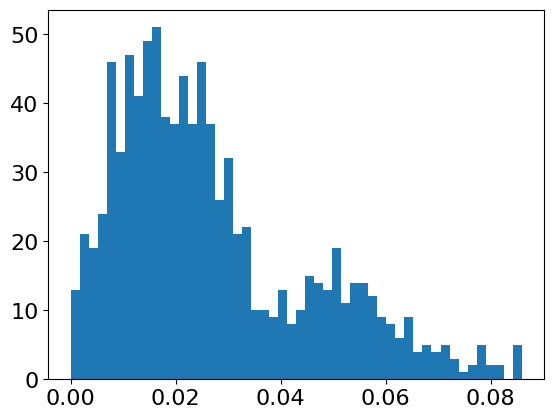

In [35]:
plt.hist(table_test_1.preds,50)

In [59]:
torch.round(test_preds[0])

TypeError: round(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [112]:
table_test[table_test.preds > 0.09]

,labels,preds


In [42]:
table_test[table_test.preds > 0.05]

,labels,preds
54,0,0.059380
60,0,0.086482
103,0,0.050511
135,0,0.055463
148,0,0.053820
...,...,...
43683,0,0.051220
43693,0,0.052986
43697,0,0.062171
43723,0,0.052685


In [ ]:
preds = []
for i in test_preds:
    if i < 0.01:
        preds.append(0)
    else:
        preds.append(1)
test_preds = preds

In [ ]:
###roc

In [36]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [35]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_labels, test_preds)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(test_labels, test_preds)

In [37]:
print('roc_auc_score for DecisionTree: ', roc_auc_score(test_labels, test_preds))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(test_labels, test_preds))

roc_auc_score for DecisionTree:  0.6387993415757107
roc_auc_score for Logistic Regression:  0.6387993415757107


In [37]:
print('roc_auc_score for Logistic Regression: ', roc_auc_score(test_labels, test_preds))

roc_auc_score for Logistic Regression:  0.656669604720058


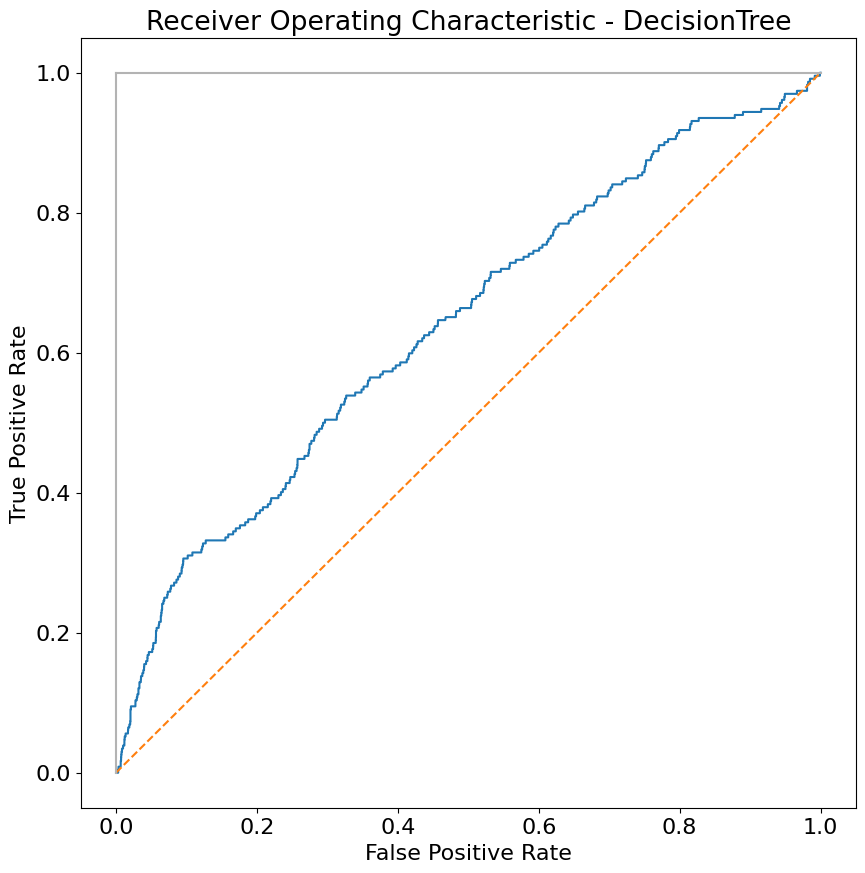

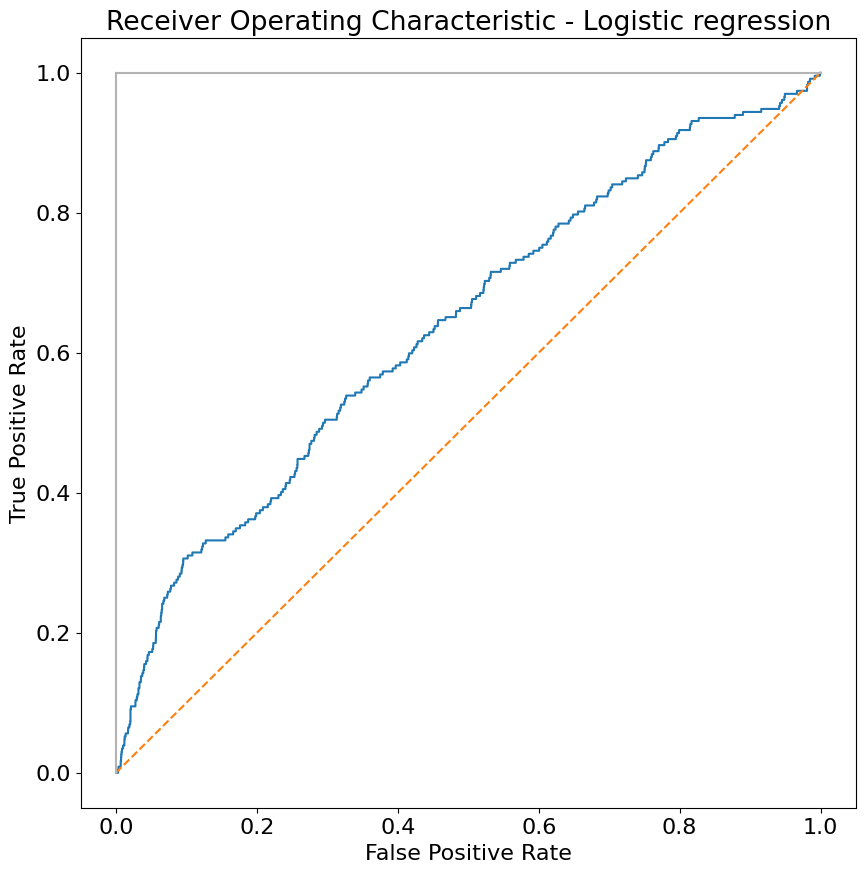

In [56]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_labels, test_preds)


In [41]:
false_positive_rate1

array([0.00000000e+00, 2.33437602e-05, 1.54068817e-03, ...,
       9.99579812e-01, 9.99579812e-01, 1.00000000e+00])

In [61]:
preds = []
for i in test_preds:
    if i < 0.016:
        preds.append(0)
    else:
        preds.append(1)
#test_preds = preds

In [62]:
test_metrics = calculate_metrics(test_labels, preds)
print("Test Metrics:", test_metrics)

Test Metrics: {'AUC': 0.6155397647090142, 'F1': 0.061171797418073486, 'Accuracy': 0.5679553971300613, 'Recall': 0.6652267818574514, 'Precision': 0.0320599562818778}


In [63]:
table_test.to_csv("/media/jan.solarz/PortableSSD/train_data_resnet.csv")

In [140]:
model1 = ResNet50Network(output_size=1, no_columns=4)
#model.to('cuda')

# Wczytanie wag zapisanych w pliku
model1.load_state_dict(torch.load('/media/jan.solarz/PortableSSD/resnet_model.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [142]:
test_df = pd.read_csv("/media/jan.solarz/PortableSSD/test_main_0.2.csv")
test_df = test_df
test_df_0 = test_df[test_df.cancer == 1].reset_index().head(20)
test_df_1 = test_df[test_df.cancer == 0].reset_index().head(200)
test_df = pd.concat([test_df_0,test_df_1]).reset_index()

In [143]:
test_df_0 = test_df.drop('density',axis=1)

In [144]:
test_df

,level_0,index,Unnamed: 0,patient_id,image_id,laterality,view,age,implant,path,cancer,density
0,0,74,4875,1524,1856057994,1,5,81.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,2
1,1,104,31779,44062,212955895,1,1,70.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,4
2,2,122,25797,37573,980979462,0,1,66.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,4
3,3,127,36954,49636,1682308781,0,5,69.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,4
4,4,200,29408,41359,1666009039,0,5,60.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
215,195,199,6961,17500,2103414182,0,5,50.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,4
216,196,201,26813,38669,1577862633,0,5,54.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,1
217,197,202,27150,38996,1997496063,0,1,59.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,1
218,198,204,25584,37348,2007997293,1,5,59.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,4


In [145]:
test_df_0

,level_0,index,Unnamed: 0,patient_id,image_id,laterality,view,age,implant,path,cancer
0,0,74,4875,1524,1856057994,1,5,81.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1
1,1,104,31779,44062,212955895,1,1,70.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1
2,2,122,25797,37573,980979462,0,1,66.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1
3,3,127,36954,49636,1682308781,0,5,69.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1
4,4,200,29408,41359,1666009039,0,5,60.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1
...,...,...,...,...,...,...,...,...,...,...,...
215,195,199,6961,17500,2103414182,0,5,50.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0
216,196,201,26813,38669,1577862633,0,5,54.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0
217,197,202,27150,38996,1997496063,0,1,59.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0
218,198,204,25584,37348,2007997293,1,5,59.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0


In [146]:
dataset = RSNADataset(test_df_0, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
test_loader = DataLoader(dataset, batch_size=3, shuffle=False)

In [147]:
csv_columns = ['laterality', 'view', 'age', 'implant']

In [149]:
model1.eval()

ResNet50Network(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [157]:
test_preds = []
test_labels = []

# Przechodzenie przez dane testowe i uzyskiwanie predykcji
with torch.no_grad():
    for data in test_loader:
        images, meta, labels = data_to_device(data)  # Załóż, że masz funkcję data_to_device
        outputs = model1(images, meta)
        preds = torch.sigmoid(outputs)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

In [159]:
print('roc_auc_score for Logistic Regression: ', roc_auc_score(test_labels, test_preds))

roc_auc_score for Logistic Regression:  0.51175


In [ ]:
table_test = pd.DataFrame({'labels':test_labels,'preds':test_preds.flatten()})

In [164]:
preds = []
for i in test_preds:
    if i < 0.0520:
        preds.append(0)
    else:
        preds.append(1)
#test_preds = preds

In [165]:
test_metrics = calculate_metrics(test_labels, test_preds)
print("Test Metrics:", test_metrics)

Test Metrics: {'AUC': 0.51175, 'F1': 0.0, 'Accuracy': 0.9090909090909091, 'Recall': 0.0, 'Precision': 0.0}


In [166]:
test_metrics = calculate_metrics(test_labels, preds)
print("Test Metrics:", test_metrics)

Test Metrics: {'AUC': 0.58, 'F1': 0.25, 'Accuracy': 0.8909090909090909, 'Recall': 0.2, 'Precision': 0.3333333333333333}


In [167]:
confusion_matrix(test_labels, preds)

array([[192,   8],
       [ 16,   4]])

In [276]:
optimal_f1(test_labels, test_preds)[1]

0.018000000000000002

In [81]:
#model resnet z density

In [168]:
model2 = ResNet50Network(output_size=1, no_columns=5)
#model.to('cuda')

# Wczytanie wag zapisanych w pliku
model2.load_state_dict(torch.load('/media/jan.solarz/PortableSSD/resnet_model_0.8_main.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [169]:
model2.eval()

ResNet50Network(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [170]:
dataset = RSNADataset(test_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
test_loader = DataLoader(dataset, batch_size=3, shuffle=False)

In [171]:
csv_columns = ['laterality', 'view', 'age', 'implant', 'density']

In [176]:
test_preds_1 = []
test_labels = []

# Przechodzenie przez dane testowe i uzyskiwanie predykcji
with torch.no_grad():
    for data in test_loader:
        images, meta, labels = data_to_device(data)  # Załóż, że masz funkcję data_to_device
        outputs = model2(images, meta)
        preds = torch.sigmoid(outputs)
        test_preds_1.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds_1)
test_labels = np.array(test_labels)

In [274]:
optimal_f1(test_labels, test_preds)

(array([0.26785714]), 0.018000000000000002)

In [216]:
print('roc_auc_score for Logistic Regression: ', roc_auc_score(test_labels, test_preds))

roc_auc_score for Logistic Regression:  0.658


In [232]:
preds = []
for i in test_preds:
    if i < 0.018000000000000002:
        preds.append(0)
    else:
        preds.append(1)

In [233]:
confusion_matrix(test_labels, preds)

array([[123,  77],
       [  5,  15]])

In [25]:
def micro_f1(true_labels, predicted_labels):
    tp = sum((true == 1 and pred == 1) for true, pred in zip(true_labels, predicted_labels))
    fn = sum((true == 1 and pred == 0) for true, pred in zip(true_labels, predicted_labels))
    tn = sum((true == 0 and pred == 0) for true, pred in zip(true_labels, predicted_labels))
    fp = sum((true == 0 and pred == 1) for true, pred in zip(true_labels, predicted_labels))
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    micf1 = tp / (tp + 0.5*(tp+fn))
    return micf1

def optimal_f1(labels, predictions):
    thres = np.linspace(0, 1, 1001)
    f1s = [pfbeta(labels, predictions > thr) for thr in thres]
    idx = np.argmax(f1s)
    return f1s[idx], thres[idx]
def pfbeta(labels, predictions, beta=1.):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / max(y_true_count, 1)  # avoid / 0
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

def balanced_accuracy(true_labels, predicted_labels):
    tp = sum((true == 1 and pred == 1) for true, pred in zip(true_labels, predicted_labels))
    fn = sum((true == 1 and pred == 0) for true, pred in zip(true_labels, predicted_labels))
    tn = sum((true == 0 and pred == 0) for true, pred in zip(true_labels, predicted_labels))
    fp = sum((true == 0 and pred == 1) for true, pred in zip(true_labels, predicted_labels))
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    b_acc = (sensitivity + specificity) / 2
    return b_acc
from sklearn.metrics import precision_recall_fscore_support

def macro_f1_score(true_labels, predicted_labels):
    # Get precision, recall, and F1 scores for each class
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)
    
    # Calculate the macro F1 score as the unweighted mean of F1 scores
    macro_f1 = sum(f1) / len(f1)
    return macro_f1
def calculate_metrics(labels, preds):
    trasheold = optimal_f1(labels, preds)[1]
    preds_fix = []
    for i in test_preds:
        if i < trasheold:
            preds_fix.append(0)
        else:
            preds_fix.append(1)
    auc = roc_auc_score(labels, preds)
    f1 = f1_score(labels, np.round(preds_fix))
    macro = macro_f1_score(labels, preds_fix)
    micro = micro_f1(labels, preds_fix)
    bacc = balanced_accuracy(labels, preds_fix)
    accuracy = accuracy_score(labels, preds_fix)
    recall = recall_score(labels, preds_fix)
    precision = precision_score(labels, preds_fix)
    class_names = ['Negative', 'Positive']

    # Compute confusion matrix
    confusion_mat = confusion_matrix(labels, preds_fix)

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(labels, preds)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate2, true_positive_rate2)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return {'AUC': auc, 'F1': f1, 'Macro F1': macro,"Micro F1": micro, "Balanced Accuracy": bacc,'Accuracy': accuracy, 'Recall': recall, 'Precision': precision,
           }
     # Replace class_names with your actual class names


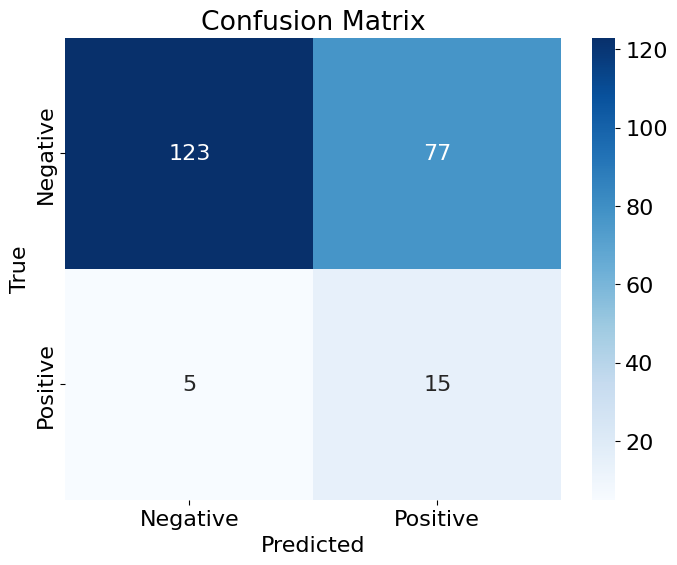

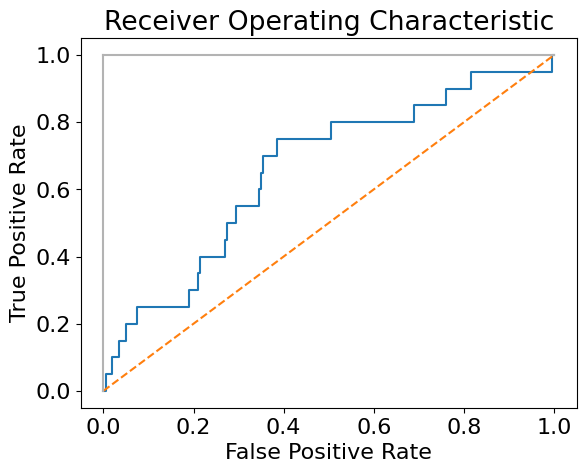

{'AUC': 0.658,
 'F1': 0.26785714285714285,
 'Macro F1': 0.5089285714285714,
 'Micro F1': 0.6,
 'Balanced Accuracy': 0.6825,
 'Accuracy': 0.6272727272727273,
 'Recall': 0.75,
 'Precision': 0.16304347826086957}

In [304]:
calculate_metrics(test_labels, test_preds)

In [ ]:
#model effnet

In [309]:
model2 = EffNetNetwork(output_size=1, no_columns=5)
#model.to('cuda')

# Wczytanie wag zapisanych w pliku
model2.load_state_dict(torch.load('/media/jan.solarz/PortableSSD/effnet_model_0.8_main.pth',map_location=torch.device('cpu')))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [310]:
model2.eval()

EffNetNetwork(
  (features): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePa

In [312]:
dataset = RSNADataset(test_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
test_loader = DataLoader(dataset, batch_size=3, shuffle=False)
csv_columns = ['laterality', 'view', 'age', 'implant', 'density']

In [313]:
test_preds_1 = []
test_labels = []

# Przechodzenie przez dane testowe i uzyskiwanie predykcji
with torch.no_grad():
    for data in test_loader:
        images, meta, labels = data_to_device(data)  # Załóż, że masz funkcję data_to_device
        outputs = model2(images, meta)
        preds = torch.sigmoid(outputs)
        test_preds_1.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds_1)
test_labels = np.array(test_labels)

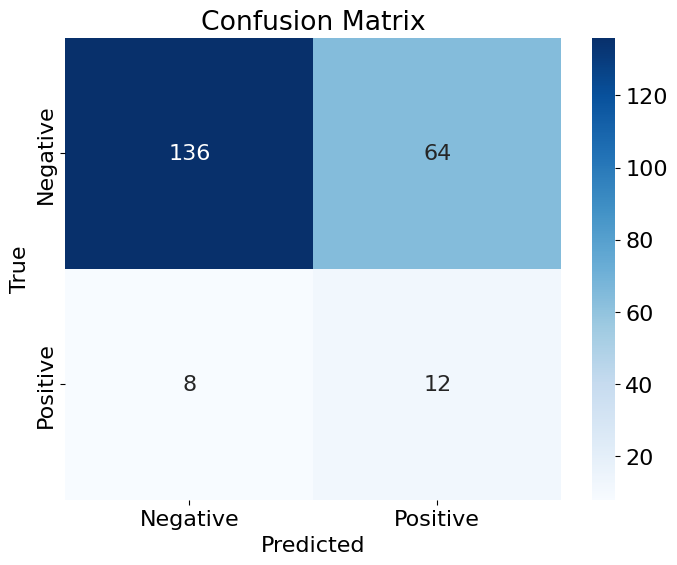

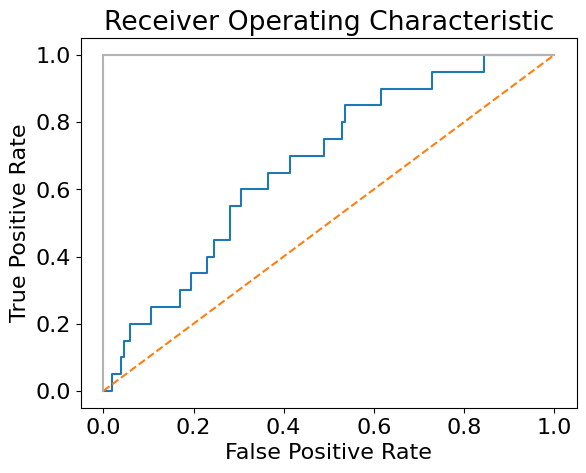

{'AUC': 0.6749999999999999,
 'F1': 0.25,
 'Macro F1': 0.5203488372093024,
 'Micro F1': 0.5454545454545454,
 'Balanced Accuracy': 0.64,
 'Accuracy': 0.6727272727272727,
 'Recall': 0.6,
 'Precision': 0.15789473684210525}

In [314]:
calculate_metrics(test_labels, test_preds)

In [315]:
#VGG19

In [15]:
import torch.nn as nn
from torchvision.models import vgg19

class VGG19Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = vgg19(pretrained=True).features # Without the classification part
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(25338, self.output_size))  # VGG19 features have 4096 dimensions
        
        
    def forward(self, image, meta, prints=False):   
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = image.view(image.size(0), -1)  # Flatten image features
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


In [16]:
# Sample data
sample_df = train1.head(6)

# Instantiate Dataset object
dataset = RSNADataset(sample_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(clr.S + f"Batch: {k}" + clr.E, "\n" +
          clr.S + "Image:" + clr.E, image.shape, "\n" +
          clr.S + "Meta:" + clr.E, meta, "\n" +
          clr.S + "Targets:" + clr.E, targets, "\n" +
          "="*50)

Batch: 0 
Image: torch.Size([3, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 61.,  0.,  4.],
        [ 1.,  1., 51.,  0.,  1.],
        [ 0.,  5., 65.,  0.,  1.]], device='cuda:0') 
Targets: tensor([0, 0, 1], device='cuda:0') 
Batch: 1 
Image: torch.Size([3, 3, 224, 224]) 
Meta: tensor([[ 0.,  5., 73.,  0.,  4.],
        [ 1.,  5., 64.,  0.,  4.],
        [ 1.,  1., 52.,  0.,  4.]], device='cuda:0') 
Targets: tensor([0, 0, 0], device='cuda:0') 


In [17]:
model_example3 = VGG19Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Outputs
out = model_example3(image, meta, prints=True)

# Criterion example
criterion_example = nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 
print("="*50)
print(clr.S+'Loss:'+clr.E, loss.item())

Input Image shape: torch.Size([3, 3, 224, 224]) 
Input metadata shape: torch.Size([3, 5])
Features Image shape: torch.Size([3, 25088])
Meta Data: torch.Size([3, 250])
Concatenated Data: torch.Size([3, 25338])
Out shape: torch.Size([3, 1])
Loss: 83.54930877685547


---------- Fold: 1 ----------


1368it [42:39,  1.87s/it]
2736it [46:34,  1.02s/it]


1:29:14 | Epoch: 1/5 | Loss: 752.5 | Acc_tr: 0.978 | Acc_vd: 0.978 | ROC: 0.595


1368it [45:57,  2.02s/it]
2736it [45:29,  1.00it/s]

1:31:27 | Epoch: 2/5 | Loss: 4.338e+03 | Acc_tr: 0.976 | Acc_vd: 0.978 | ROC: 0.628



1368it [45:49,  2.01s/it]
2736it [46:01,  1.01s/it]


1:31:51 | Epoch: 3/5 | Loss: 625.6 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.63


1368it [45:29,  2.00s/it]
2736it [45:29,  1.00it/s]

1:31:00 | Epoch: 4/5 | Loss: 138.5 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.632



1368it [44:57,  1.97s/it]
2736it [45:24,  1.00it/s]


1:30:22 | Epoch: 5/5 | Loss: 137.4 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.647


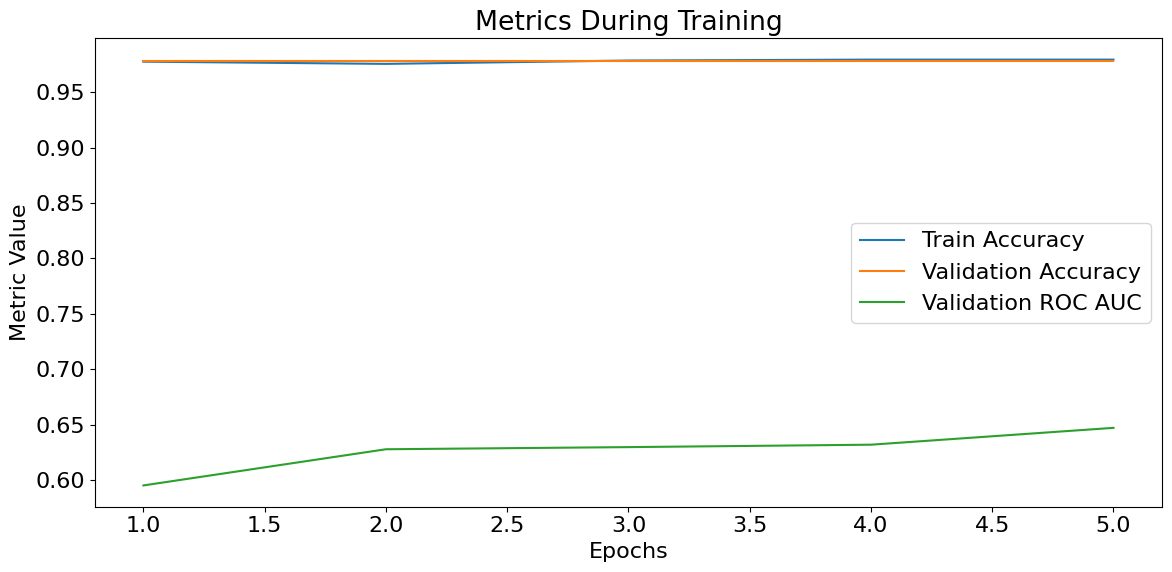

---------- Fold: 2 ----------


1368it [45:22,  1.99s/it]
2736it [51:51,  1.14s/it]


1:37:14 | Epoch: 1/5 | Loss: 142.9 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.627


1368it [50:11,  2.20s/it]
2736it [46:41,  1.02s/it]

1:36:53 | Epoch: 2/5 | Loss: 4.566e+05 | Acc_tr: 0.977 | Acc_vd: 0.979 | ROC: 0.65



1368it [1:03:04,  2.77s/it]
2736it [1:25:27,  1.87s/it]

2:28:32 | Epoch: 3/5 | Loss: 142.8 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.647



1368it [1:04:03,  2.81s/it]
2736it [55:29,  1.22s/it]

1:59:33 | Epoch: 4/5 | Loss: 142.5 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.633
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.



1368it [51:29,  2.26s/it]
2736it [48:00,  1.05s/it]


1:39:30 | Epoch: 5/5 | Loss: 141.3 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.632
Early stopping (no improvement since 3 models) | Best ROC: 0.649999777556622


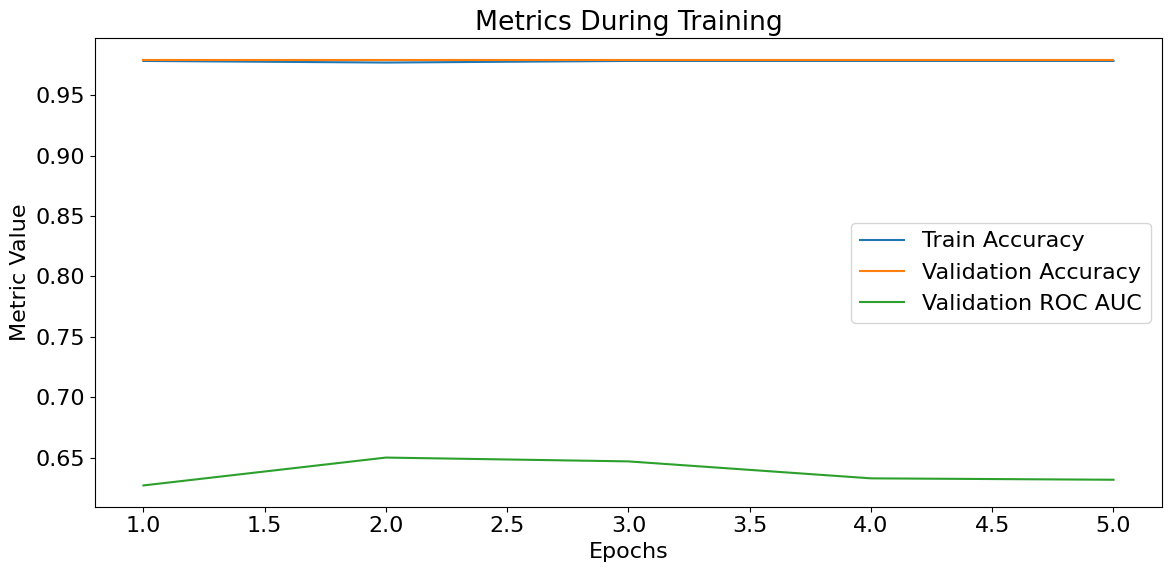

In [19]:
FOLDS = 2
EPOCHS = 5
PATIENCE = 3
WORKERS = 8
LR = 0.0005
WD = 0.0
LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
LR_FACTOR = 0.4            # by how much the lr is decreasing

BATCH_SIZE1 = 16          # for train
BATCH_SIZE2 = 8           # for valid

VERSION = 'v1'
MODEL = 'vgg19'

model3 = VGG19Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# ------------------

# Run the cell below to train
# Ran it locally on all data, see the results below
train_folds(model=model3, train_original=train1)

In [20]:
torch.save(model3.state_dict(), '/media/jan.solarz/PortableSSD/vgg19_model_0.8_main.pth')

In [57]:
model3 = VGG19Network(output_size=1, no_columns=5)
#model.to('cuda')

# Wczytanie wag zapisanych w pliku
model3.load_state_dict(torch.load('/media/jan.solarz/PortableSSD/vgg19_model_0.8_main.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [58]:
model3.eval()

VGG19Network(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

In [59]:
test_df

,level_0,index,Unnamed: 0,patient_id,image_id,laterality,view,age,implant,path,cancer,density
0,0,74,4875,1524,1856057994,1,5,81.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,2
1,1,104,31779,44062,212955895,1,1,70.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,4
2,2,122,25797,37573,980979462,0,1,66.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,4
3,3,127,36954,49636,1682308781,0,5,69.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,4
4,4,200,29408,41359,1666009039,0,5,60.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
215,195,199,6961,17500,2103414182,0,5,50.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,4
216,196,201,26813,38669,1577862633,0,5,54.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,1
217,197,202,27150,38996,1997496063,0,1,59.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,1
218,198,204,25584,37348,2007997293,1,5,59.0,0,/media/jan.solarz/PortableSSD/kaggle/input/rsn...,0,4


In [63]:
test_df = pd.read_csv("/media/jan.solarz/PortableSSD/test_main_0.2.csv")
test_df = test_df
test_df_0 = test_df[test_df.cancer == 1].reset_index().head(20)
test_df_1 = test_df[test_df.cancer == 0].reset_index().head(200)
test_df = pd.concat([test_df_0,test_df_1]).reset_index()
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev=torch.device("cuda") 
model3.to(dev)

VGG19Network(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

In [61]:
dataset = RSNADataset(test_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
test_loader = DataLoader(dataset, batch_size=8, shuffle=False)
csv_columns = ['laterality', 'view', 'age', 'implant', 'density']

In [62]:
test_preds_1 = []
test_labels = []

# Przechodzenie przez dane testowe i uzyskiwanie predykcji
with torch.no_grad():
    for data in test_loader:
        images, meta, labels = data_to_device(data)  # Załóż, że masz funkcję data_to_device
        outputs = model3(images, meta)
        preds = torch.sigmoid(outputs)
        test_preds_1.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds_1)
test_labels = np.array(test_labels)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [ ]:
calculate_metrics(test_labels, test_preds)

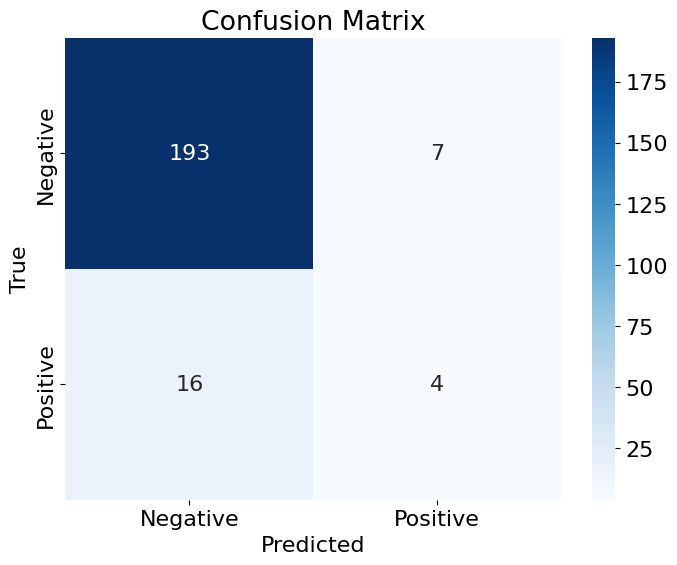

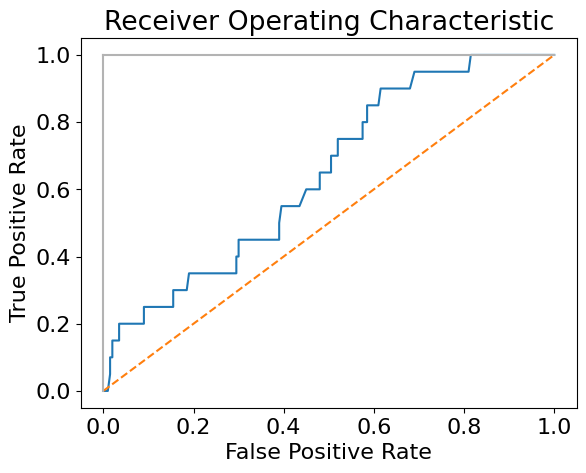

{'AUC': 0.6445,
 'F1': 0.25806451612903225,
 'Macro F1': 0.6009148986513133,
 'Micro F1': 0.2857142857142857,
 'Balanced Accuracy': 0.5825,
 'Accuracy': 0.8954545454545455,
 'Recall': 0.2,
 'Precision': 0.36363636363636365}

In [43]:
calculate_metrics(test_labels, test_preds)

In [ ]:
        epochs = np.arange(1, epoch + 2)

        plt.figure(figsize=(12, 6))
#         plt.subplot(1, 2, 1)
#         plt.plot(epochs, train_loss_epochs, label='Train Loss')
#         plt.plot(epochs, valid_loss_epochs, label='Validation Loss')
#         plt.legend()
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.title('Loss During Training')

       # plt.subplot(1, 2, 2)
       # plt.plot(epochs, train_loss_epochs, label='Train Loss')
        plt.plot(epochs, train_acc_epochs, label='Train Accuracy')
        plt.plot(epochs, valid_acc_epochs, label='Validation Accuracy')
        plt.plot(epochs, valid_roc_epochs, label='Validation ROC AUC')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Metric Value')
        plt.title('Metrics During Training')

        plt.tight_layout()
        plt.show()

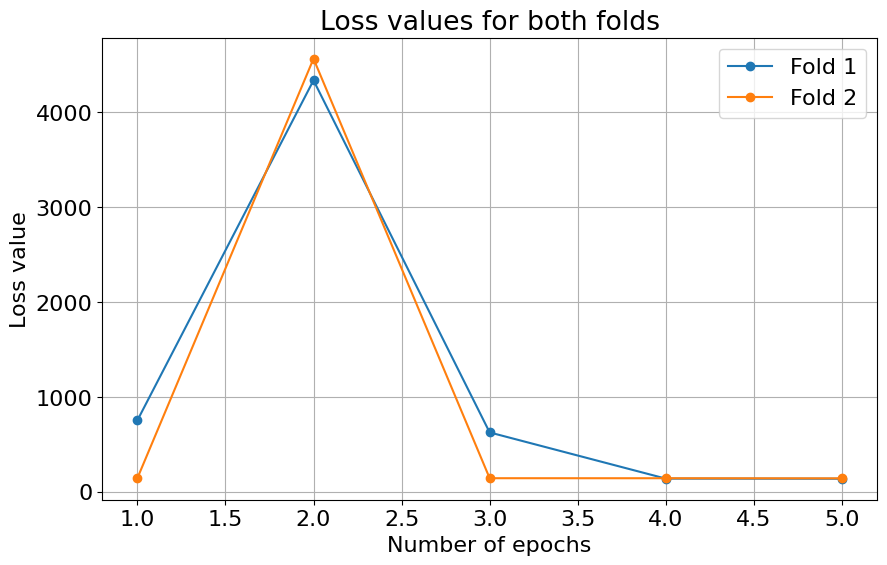

In [74]:
import matplotlib.pyplot as plt

# Dane dla Fold 1
fold1_epochs = [1, 2, 3, 4, 5]
fold1_loss = [752.5, 4338, 625.6, 138.5, 137.4]

# Dane dla Fold 2
fold2_epochs = [1, 2, 3, 4, 5]
fold2_loss = [142.9, 4566, 142.8, 142.5, 141.3]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(fold1_epochs, fold1_loss, marker='o', label='Fold 1')
plt.plot(fold2_epochs, fold2_loss, marker='o', label='Fold 2')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.title('Loss values for both folds')
plt.legend()
plt.grid(True)
plt.show()



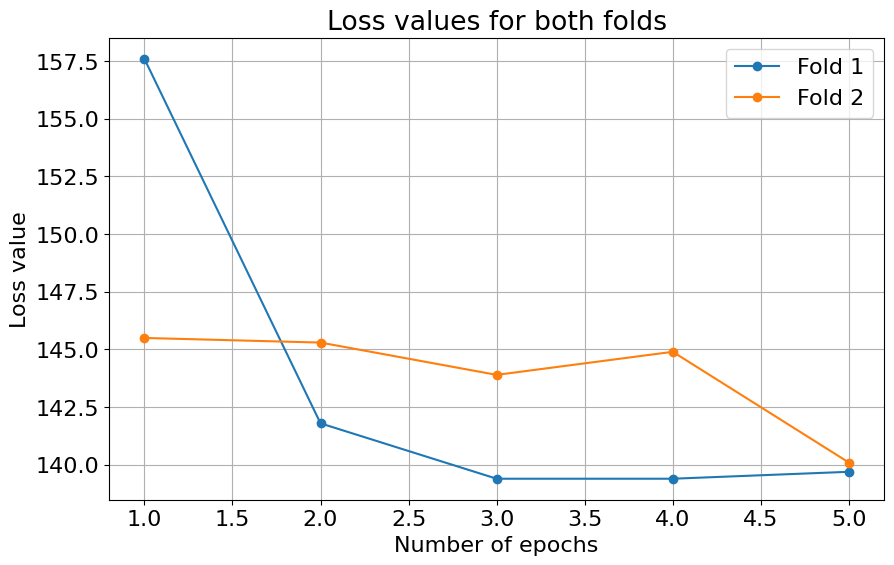

In [75]:
import matplotlib.pyplot as plt

# Dane dla Fold 1
fold1_epochs = [1, 2, 3, 4, 5]
fold1_loss = [157.6, 141.8, 139.4, 139.4, 139.7]

# Dane dla Fold 2
fold2_epochs = [1, 2, 3, 4, 5]
fold2_loss = [145.5, 145.3, 143.9, 144.9, 140.1]



# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(fold1_epochs, fold1_loss, marker='o', label='Fold 1')
plt.plot(fold2_epochs, fold2_loss, marker='o', label='Fold 2')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.title('Loss values for both folds')
plt.legend()
plt.grid(True)
plt.show()


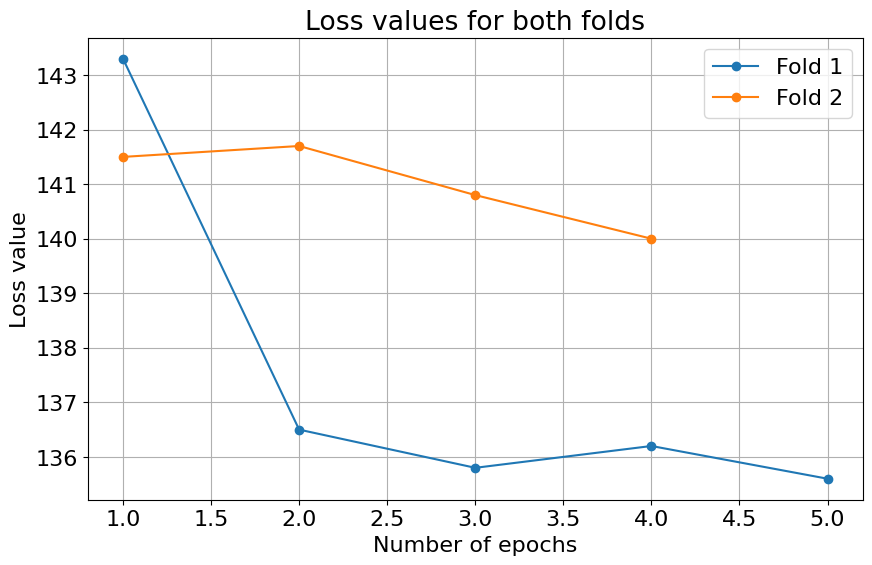

In [76]:
import matplotlib.pyplot as plt

# Dane dla Fold 1
fold1_epochs = [1, 2, 3, 4, 5]
fold1_loss = [143.3, 136.5, 135.8, 136.2, 135.6]

# Dane dla Fold 2
fold2_epochs = [1, 2, 3, 4]
fold2_loss = [141.5, 141.7, 140.8, 140.0]






plt.figure(figsize=(10, 6))
plt.plot(fold1_epochs, fold1_loss, marker='o', label='Fold 1')
plt.plot(fold2_epochs, fold2_loss, marker='o', label='Fold 2')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.title('Loss values for both folds')
plt.legend()
plt.grid(True)
plt.show()



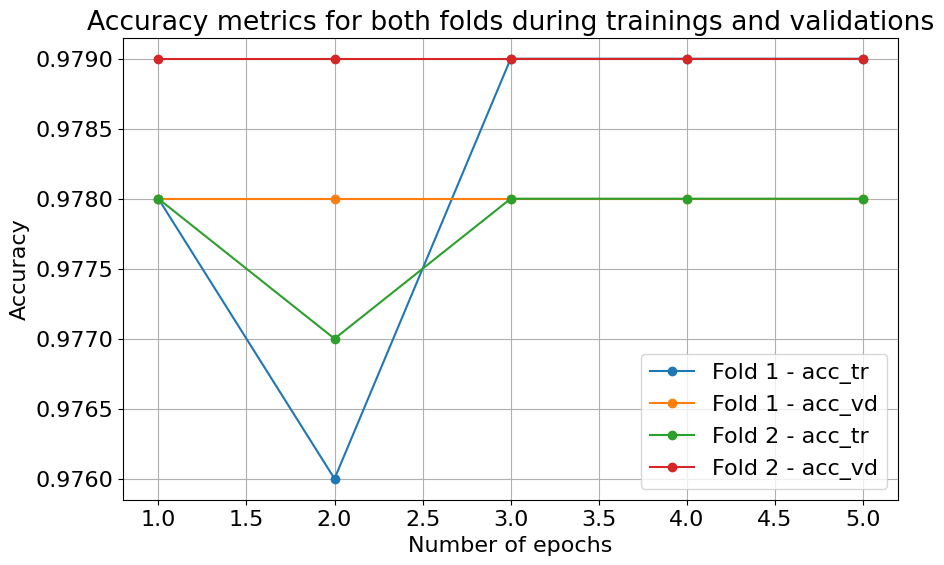

In [81]:
import matplotlib.pyplot as plt

# Dane dla Fold 1
fold1_epochs = [1, 2, 3, 4, 5]
fold1_acc_tr = [0.978, 0.976, 0.979, 0.979, 0.979]
fold1_acc_vd = [0.978, 0.978, 0.978, 0.978, 0.978]

# Dane dla Fold 2
fold2_epochs = [1, 2, 3, 4, 5]
fold2_acc_tr = [0.978, 0.977, 0.978, 0.978, 0.978]
fold2_acc_vd = [0.979, 0.979, 0.979, 0.979, 0.979]



# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(fold1_epochs, fold1_acc_tr, marker='o', label='Fold 1 - acc_tr')
plt.plot(fold1_epochs, fold1_acc_vd, marker='o', label='Fold 1 - acc_vd')
plt.plot(fold2_epochs, fold2_acc_tr, marker='o', label='Fold 2 - acc_tr')
plt.plot(fold2_epochs, fold2_acc_vd, marker='o', label='Fold 2 - acc_vd')

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy metrics for both folds during trainings and validations')
plt.legend()
plt.grid(True)
plt.show()


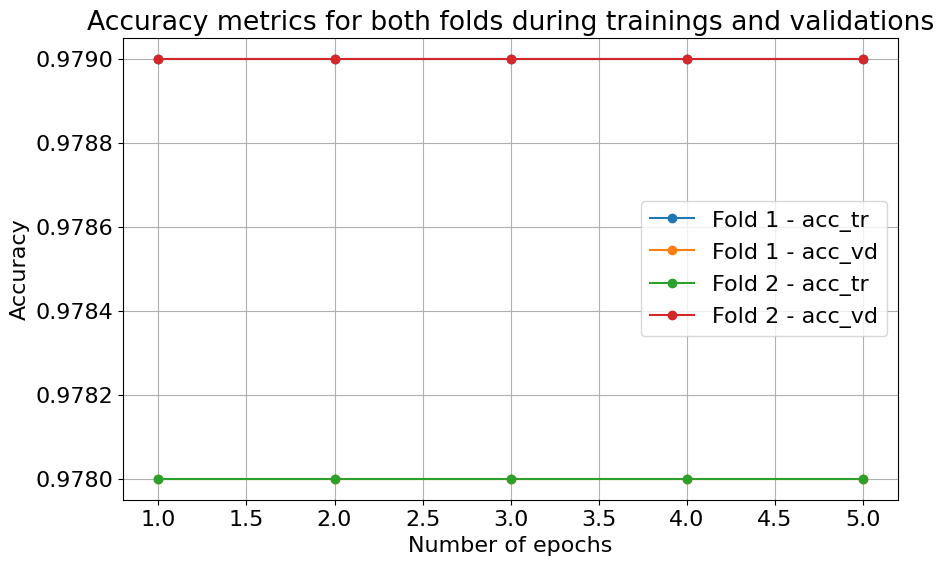

In [82]:
import matplotlib.pyplot as plt

# Dane dla Fold 1
fold1_epochs = [1, 2, 3, 4, 5]
fold1_acc_tr = [0.979, 0.979, 0.979, 0.979, 0.979]
fold1_acc_vd = [0.978, 0.978, 0.978, 0.978, 0.978]

# Dane dla Fold 2
fold2_epochs = [1, 2, 3, 4, 5]
fold2_acc_tr = [0.978, 0.978, 0.978, 0.978, 0.978]
fold2_acc_vd = [0.979, 0.979, 0.979, 0.979, 0.979]



# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(fold1_epochs, fold1_acc_tr, marker='o', label='Fold 1 - acc_tr')
plt.plot(fold1_epochs, fold1_acc_vd, marker='o', label='Fold 1 - acc_vd')
plt.plot(fold2_epochs, fold2_acc_tr, marker='o', label='Fold 2 - acc_tr')
plt.plot(fold2_epochs, fold2_acc_vd, marker='o', label='Fold 2 - acc_vd')

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy metrics for both folds during trainings and validations')
plt.legend()
plt.grid(True)
plt.show()

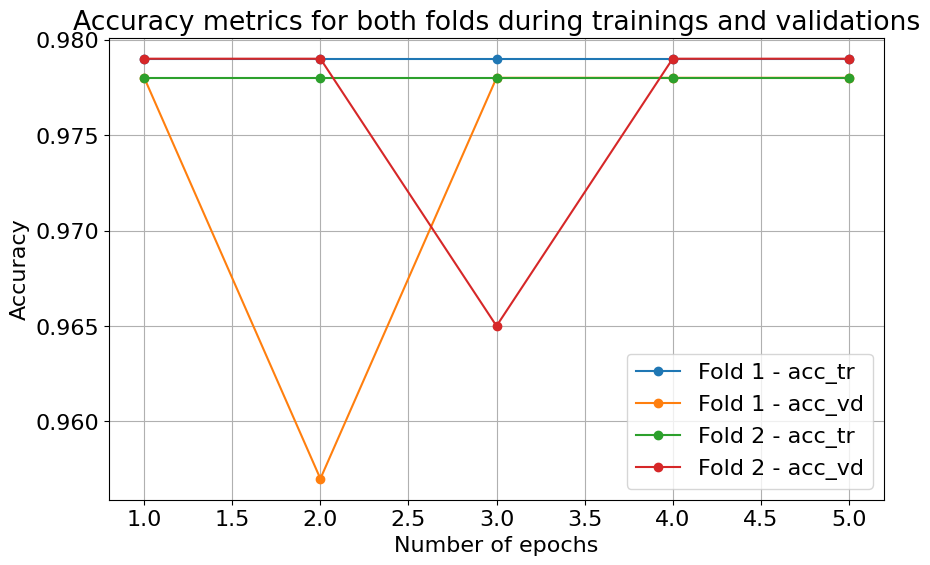

In [83]:
import matplotlib.pyplot as plt

# Dane dla Fold 1
fold1_epochs = [1, 2, 3, 4, 5]
fold1_acc_tr = [0.979, 0.979, 0.979, 0.979, 0.979]
fold1_acc_vd = [0.978, 0.957, 0.978, 0.978, 0.978]

# Dane dla Fold 2
fold2_epochs = [1, 2, 3, 4, 5]
fold2_acc_tr = [0.978, 0.978, 0.978, 0.978, 0.978]
fold2_acc_vd = [0.979, 0.979, 0.965, 0.979, 0.979]



# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(fold1_epochs, fold1_acc_tr, marker='o', label='Fold 1 - acc_tr')
plt.plot(fold1_epochs, fold1_acc_vd, marker='o', label='Fold 1 - acc_vd')
plt.plot(fold2_epochs, fold2_acc_tr, marker='o', label='Fold 2 - acc_tr')
plt.plot(fold2_epochs, fold2_acc_vd, marker='o', label='Fold 2 - acc_vd')

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy metrics for both folds during trainings and validations')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
---------- Fold: 1 ----------
1:31:20 | Epoch: 1/5 | Loss: 143.3 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.622
1:31:56 | Epoch: 2/5 | Loss: 136.5 | Acc_tr: 0.979 | Acc_vd: 0.957 | ROC: 0.648
1:49:35 | Epoch: 3/5 | Loss: 135.8 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.637
2:08:21 | Epoch: 4/5 | Loss: 136.2 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.633
1:50:48 | Epoch: 5/5 | Loss: 135.6 | Acc_tr: 0.979 | Acc_vd: 0.978 | ROC: 0.653
---------- Fold: 2 ----------
1:59:16 | Epoch: 1/5 | Loss: 141.5 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.646
1:51:43 | Epoch: 2/5 | Loss: 141.7 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.644
1:52:04 | Epoch: 3/5 | Loss: 140.8 | Acc_tr: 0.978 | Acc_vd: 0.965 | ROC: 0.632
1:51:36 | Epoch: 4/5 | Loss: 140.0 | Acc_tr: 0.978 | Acc_vd: 0.979 | ROC: 0.645
Early stopping (no improvement since 3 models) | Best ROC: 0.6464721359664973

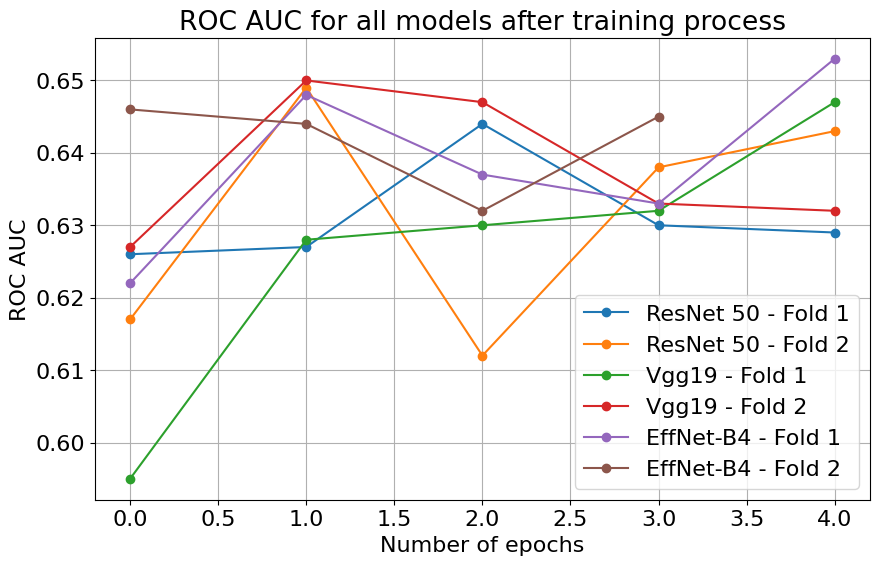

In [84]:
import matplotlib.pyplot as plt

# Dane dla Fold 1, Model 1
fold1_model1_roc = [0.626, 0.627, 0.644, 0.63, 0.629]

# Dane dla Fold 2, Model 1
fold2_model1_roc = [0.617, 0.649, 0.612, 0.638, 0.643]

# Dane dla Fold 1, Model 2
fold1_model2_roc = [0.595, 0.628, 0.63, 0.632, 0.647]

# Dane dla Fold 2, Model 2
fold2_model2_roc = [0.627, 0.65, 0.647, 0.633, 0.632]

# Dane dla Fold 1, Model 3
fold1_model3_roc = [0.622, 0.648, 0.637, 0.633, 0.653]

# Dane dla Fold 2, Model 3
fold2_model3_roc = [ 0.646, 0.644, 0.632, 0.645]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(fold1_model1_roc, marker='o', label='ResNet 50 - Fold 1')
plt.plot(fold2_model1_roc, marker='o', label='ResNet 50 - Fold 2')
plt.plot(fold1_model2_roc, marker='o', label='Vgg19 - Fold 1')
plt.plot(fold2_model2_roc, marker='o', label='Vgg19 - Fold 2')
plt.plot(fold1_model3_roc, marker='o', label='EffNet-B4 - Fold 1')
plt.plot(fold2_model3_roc, marker='o', label='EffNet-B4 - Fold 2')
plt.xlabel('Number of epochs')
plt.ylabel('ROC AUC')
plt.title('ROC AUC for all models after training process')
plt.legend()
plt.grid(True)
plt.show()

